# Laboratorium

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from functools import cmp_to_key as compare
from functools import reduce
from math import sqrt
import os

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points


class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

___

# Rozwiązanie

## Zbiór punktów nr 1

<IPython.core.display.Javascript object>


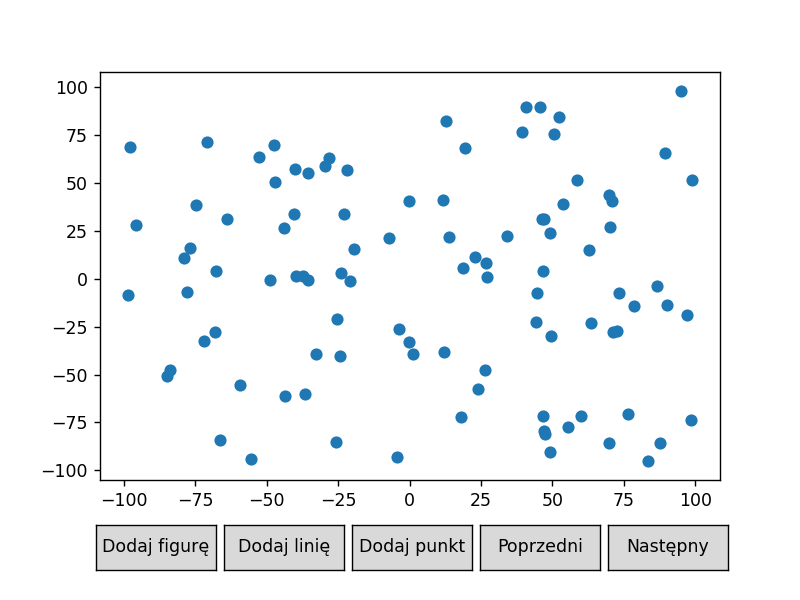

In [3]:
%matplotlib notebook

def generate_set_1(n, rang):
    x = np.random.uniform(rang[0], rang[1], n)
    y = np.random.uniform(rang[0], rang[1], n)

    return np.dstack((x, y))[0]


data_set_1 = generate_set_1(100, (-100, 100))
plot = Plot(points=[PointsCollection(data_set_1)])
plot.draw()

## Zbiór punktów nr 2

<IPython.core.display.Javascript object>


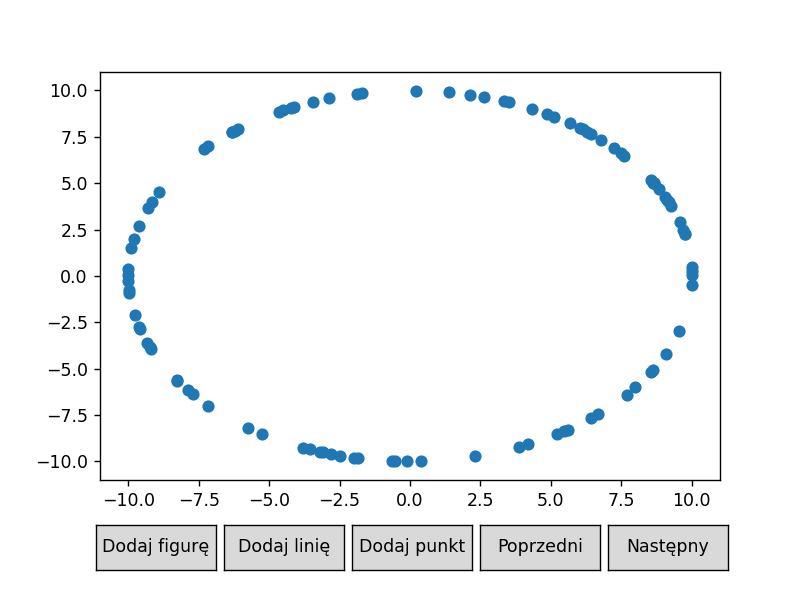

In [4]:
def generate_set_2(n, cent_pt, r):
    t = np.random.uniform(0, 2*np.pi, n)
    x = r*np.cos(t) + cent_pt[0]
    y = r*np.sin(t) + cent_pt[1]
    
    return np.dstack((x, y))[0]
    

data_set_2 = generate_set_2(100, (0, 0), 10)
plot = Plot(points=[PointsCollection(data_set_2)])
plot.draw()

## Zbiór punktów nr 3

<IPython.core.display.Javascript object>


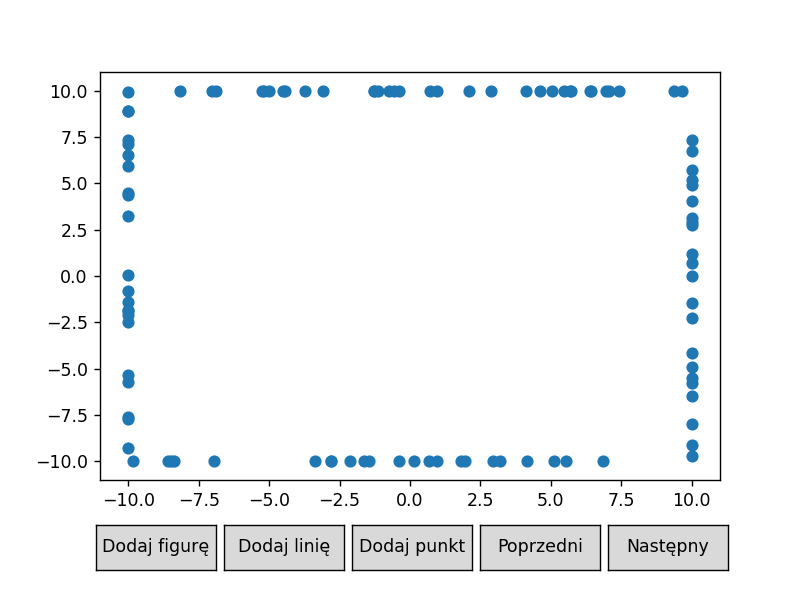

In [5]:
def generate_set_3(n, vertices):
    vertices.sort(key=lambda tup: (tup[0], tup[1]))
    
    rect_sides = [lambda x: (vertices[0][0], x*(vertices[1][1]-vertices[0][1])+vertices[0][1]),
                  lambda x: (x*(vertices[2][0]-vertices[1][0])+vertices[1][0], vertices[1][1]),
                  lambda x: (vertices[2][0], x*(vertices[2][1]-vertices[3][1])+vertices[3][1]),
                  lambda x: (x*(vertices[3][0]-vertices[0][0])+vertices[0][0], vertices[0][1])]
    
    t = np.random.uniform(0, 1, n)
    
    return np.array(list(map(lambda x: rect_sides[np.random.randint(4)](x), t)))


data_set_3 = generate_set_3(100, [(-10, 10), (-10, -10), (10, -10), (10, 10)])
plot = Plot(points=[PointsCollection(data_set_3)])
plot.draw()

## Zbiór punktów nr 4

<IPython.core.display.Javascript object>


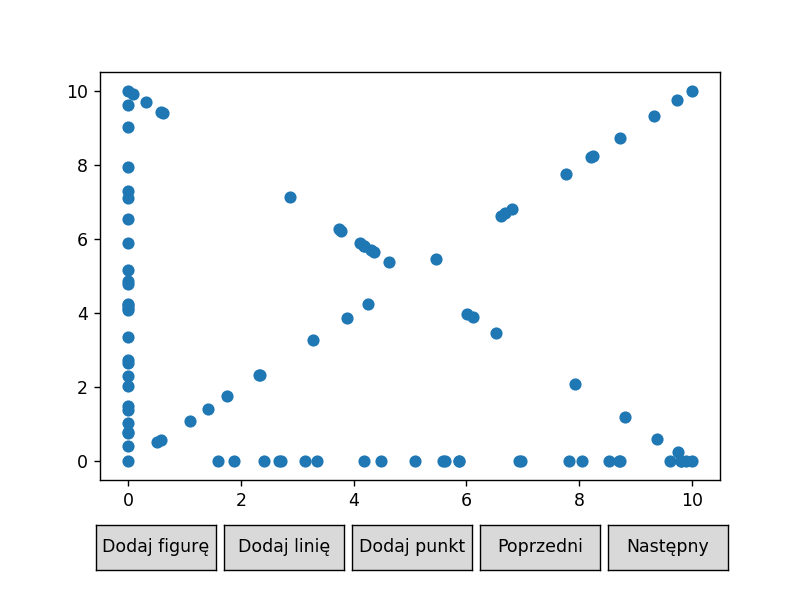

In [6]:
def generate_set_4(n_axis, n_diag, vertices):
    sides = [lambda x: (vertices[0][0], x*(vertices[1][1]-vertices[0][1])+vertices[0][1]),
             lambda x: (x*(vertices[2][0]-vertices[0][0])+vertices[0][0], vertices[0][1]),
             lambda x: (x*(vertices[3][0]-vertices[0][0])-vertices[0][0], x*(vertices[3][1]-vertices[0][1])-vertices[0][1]),
             lambda x: (x*(vertices[2][0]-vertices[1][0])+vertices[1][0], x*(vertices[2][1]-vertices[1][1])+vertices[1][1])]
    
    result_set = []
    for i in range(4):
        if i < 2:
            t = np.random.uniform(0, 1, n_axis)
        else:
            t = np.random.uniform(0, 1, n_diag)
            
        result_set.extend(list(map(lambda x: sides[i](x), t)))
        
    result_set.extend(vertices)
    
    return np.array(result_set)


data_set_4 = generate_set_4(25, 20, [(0, 0), (0, 10), (10, 0), (10, 10)])
plot = Plot(points=[PointsCollection(data_set_4)])
plot.draw()

# Implementacja funkcji pomocniczych

### Wyznacznik

In [7]:
def det_3x3(pt_a, pt_b, pt_c):
    return (pt_a[0]*pt_b[1] + pt_b[0]*pt_c[1] + pt_c[0]*pt_a[1]
           - pt_c[0]*pt_b[1] - pt_a[0]*pt_c[1] - pt_b[0]*pt_a[1])

### Obsługa nakładania się punktów do klasyfikacji względem kąta

In [8]:
def handle_overlapping(pt_a, pt_b, pt_c):
    if pt_a == pt_b:
        return -1
    if pt_a == pt_c:
        return 1

In [9]:
def angle_orientation(pt_a, pt_b, pt_c, tolerance=10e-12):
    det_val = det_3x3(pt_a, pt_b, pt_c)
    
    if det_val > tolerance:
        return -1
    elif det_val < -tolerance:
        return 1
    else:
        return 0

### Klasyfikacja punktów względem kąta

In [10]:
def angle_classification(pt_a, pt_b, pt_c, tolerance):
    result_ovrl = handle_overlapping(pt_a, pt_b, pt_c)
    
    if result_ovrl in (-1, 1):
        return result_ovrl
    
    return angle_orientation(pt_a, pt_b, pt_c, tolerance)

### Usunięcie punktów współliniowych

In [11]:
def remove_collinear(data_set, min_pt, tolerance):
    idx = 1
    removed = []
    
    while idx < len(data_set)-1:
        det_val = det_3x3(min_pt, data_set[idx], data_set[idx+1])
        
        if abs(det_val) < tolerance:
            if dist(data_set[idx], min_pt) < dist(data_set[idx+1], min_pt):
                removed.append(data_set[idx])
                data_set.pop(idx)
            else:
                removed.append(data_set[idx+1])
                data_set.pop(idx+1)
        else:
            idx += 1
            
    return data_set, removed

### Dystans punktu do linii

In [12]:
def distance_to_line(pt, line_pt_1, line_pt_2):
    x_diff = line_pt_2[0] - line_pt_1[0]
    y_diff = line_pt_2[1] - line_pt_1[1]
    numerator = abs(y_diff*pt[0] - x_diff*pt[1] + line_pt_2[0]*line_pt_1[1] - line_pt_2[1]*line_pt_1[0])
    denumerator = sqrt(y_diff**2 + x_diff**2)
    return numerator/denumerator

### Obsługa wizualizacji kroków algorytmu Grahama oraz Jarvisa

In [13]:
def generate_scene(data_set, stack, idx, removed_data=[], last_scene=False, data_color="blue", 
                   stack_color="magenta", last_pt_color="gold", removed_color="black"):
    
    stack_lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    last_line = [(data_set[idx], stack[-1])]
    
    if last_scene:
        stack_lines.append([stack[-1], stack[0]])
        return Scene([PointsCollection(data_set), 
                      PointsCollection(stack, color=stack_color),
                      PointsCollection(removed_data, color=removed_color)], 
                     [LinesCollection(stack_lines, color=stack_color)])
        
    return Scene([PointsCollection(data_set),  
                  PointsCollection([data_set[idx]], color=last_pt_color),
                  PointsCollection(stack.copy(), color=stack_color)],
                 [LinesCollection(last_line, color=last_pt_color),
                  LinesCollection(stack_lines, color=stack_color)])

### Zapis punktów otoczki

In [14]:
def save_file(file_content, filename, mode="w"):
    results_directory = os.path.join(os.getcwd(), r"results")
    
    if not os.path.exists(results_directory):
        os.makedirs(results_directory)
    with open(os.path.join(results_directory, filename), mode) as file:
        for pt in file_content:
            file.write(f"{pt},\n")

# Algorytm Grahama

In [15]:
def graham_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_graham.txt"):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    sorted_data = sorted(data_set, key=compare(lambda x, y: angle_classification(min_pt, x, y, tolerance)))
    sorted_data, removed_data = remove_collinear(sorted_data, min_pt, tolerance)
    
    scenes, stack = [], []
    stack.extend(sorted_data[:3])
    idx = len(stack)
    
    while idx < len(sorted_data):
        new_scene = generate_scene(sorted_data, stack, idx)
        scenes.append(new_scene)
        
        pt_a, pt_b = stack[-2], stack[-1]
        pt_next = sorted_data[idx]
        
        if angle_orientation(pt_a, pt_b, pt_next) == -1:
            stack.append(pt_next)
            idx += 1
        else:
            stack.pop()
    
    if angle_orientation(pt_a, pt_b, min_pt) == 0:
        stack.pop()
        
    last_scene = generate_scene(sorted_data, stack, idx-1, removed_data=removed_data, last_scene=True)
    scenes.insert(0, last_scene)
    
    if save_results:
        save_file(stack, filename=filename)
        
    return scenes

## Algorytm Grahama dla zbioru punktów nr 1

In [16]:
convex_hull_1 = graham_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_graham.txt")
plot = Plot(scenes=convex_hull_1)
plot.draw()

<IPython.core.display.Javascript object>

## Algorytm Grahama dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


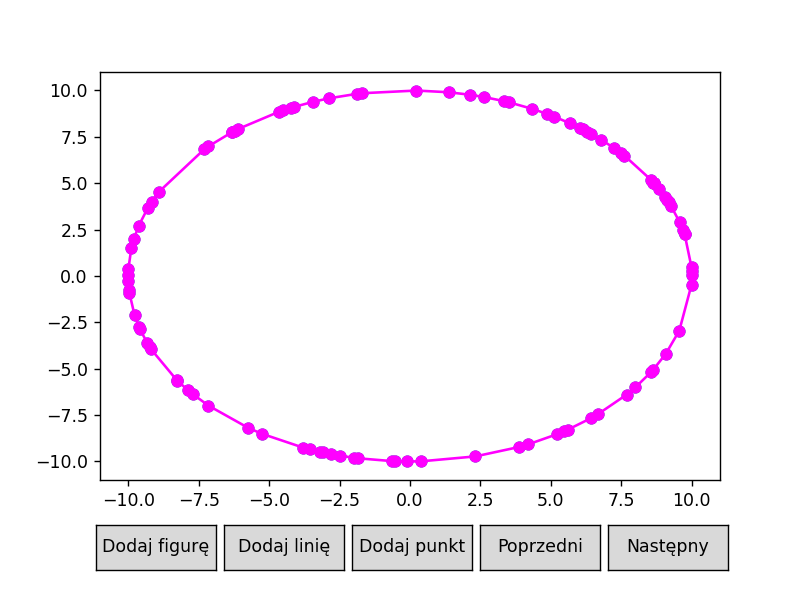

In [17]:
convex_hull_2 = graham_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_graham.txt")
plot = Plot(scenes=convex_hull_2)
plot.draw()

## Algorytm Grahama dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


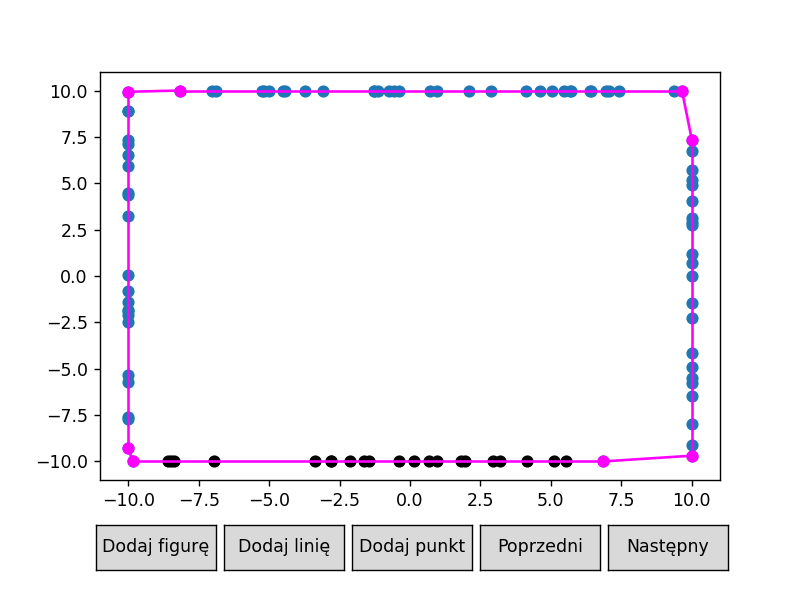

In [18]:
convex_hull_3 = graham_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_graham.txt")
plot = Plot(scenes=convex_hull_3)
plot.draw()

## Algorytm Grahama dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


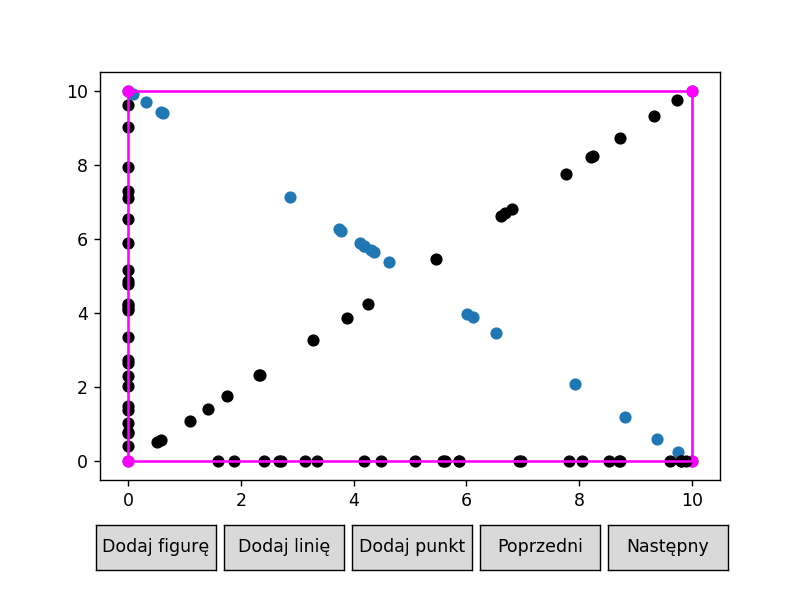

In [19]:
convex_hull_4 = graham_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_graham.txt")
plot = Plot(scenes=convex_hull_4)
plot.draw()

# Algorytm Jarvisa

In [20]:
def min_angle(pt_stack, pt_last, pt_next, tolerance=10e-12):
    if pt_stack == pt_last:
        return pt_next
    elif angle_orientation(pt_stack, pt_last, pt_next) == 1:
        return pt_next
    elif (angle_orientation(pt_stack, pt_last, pt_next) == 0 
        and dist(pt_stack, pt_next) > dist(pt_stack, pt_last)):
        return pt_next
    else:
        return pt_last

In [21]:
def jarvis_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_jarvis.txt"):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    scenes, stack = [], []
    pt_stack = min_pt
    
    while True:
        stack.append(pt_stack)
        pt_last = data_set[0]
        
        for idx in range(len(data_set)):
            new_scene = generate_scene(data_set, stack, idx)
            scenes.append(new_scene)
            pt_last = min_angle(pt_stack, pt_last, data_set[idx])
        
        pt_stack = pt_last
        if pt_stack == min_pt:
            break
    
    last_scene = generate_scene(data_set, stack, idx-1, last_scene=True)
    scenes.insert(0, last_scene)
    
    if save_results:
        save_file(stack, filename=filename)
    
    return scenes

## Algorytm Jarvisa dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


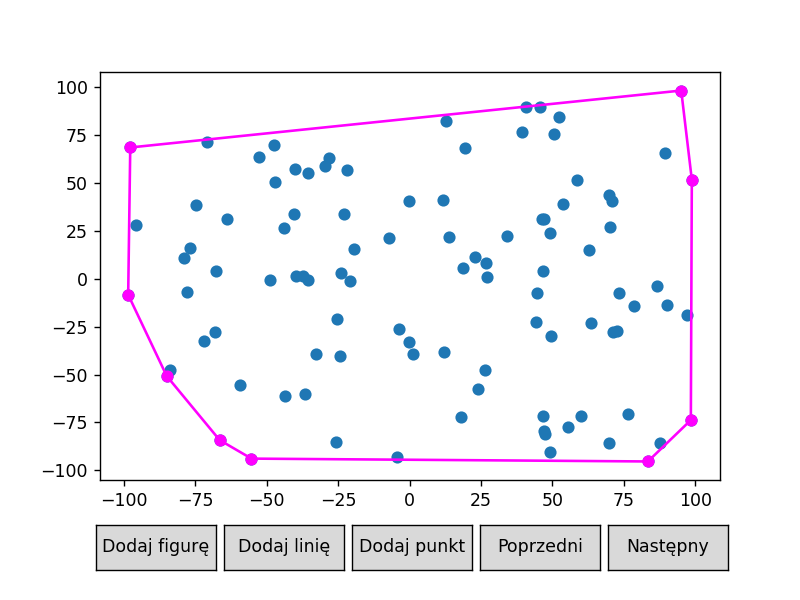

In [22]:
convex_hull_1_jarvis = jarvis_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_jarvis.txt")
plot = Plot(scenes=convex_hull_1_jarvis)
plot.draw()

## Algorytm Jarvisa dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


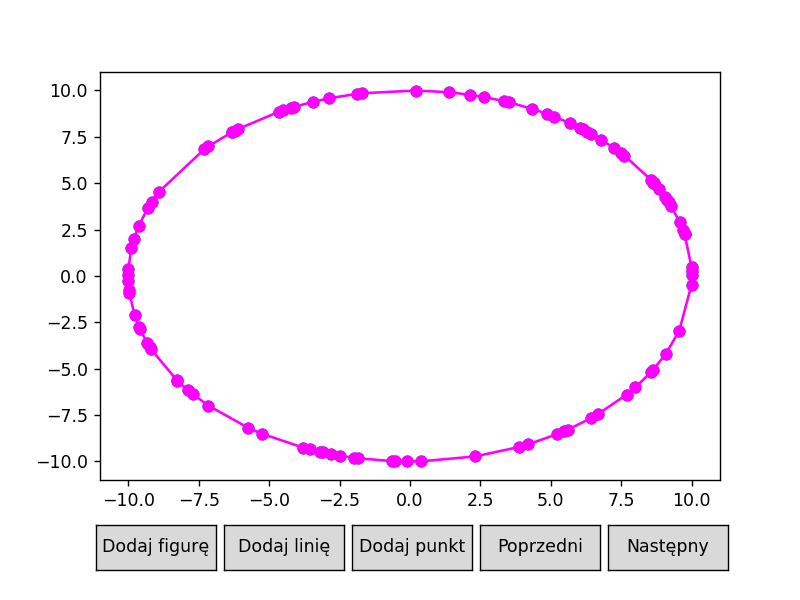

In [23]:
convex_hull_2_jarvis = jarvis_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_jarvis.txt")
plot = Plot(scenes=convex_hull_2_jarvis)
plot.draw()

## Algorytm Jarvisa dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


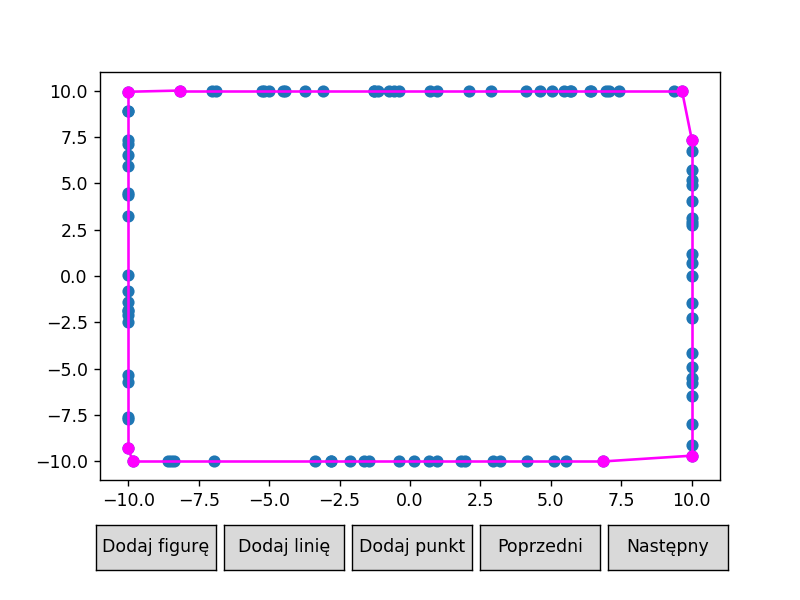

In [24]:
convex_hull_3_jarvis = jarvis_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_jarvis.txt")
plot = Plot(scenes=convex_hull_3_jarvis)
plot.draw()

## Algorytm Jarvisa dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


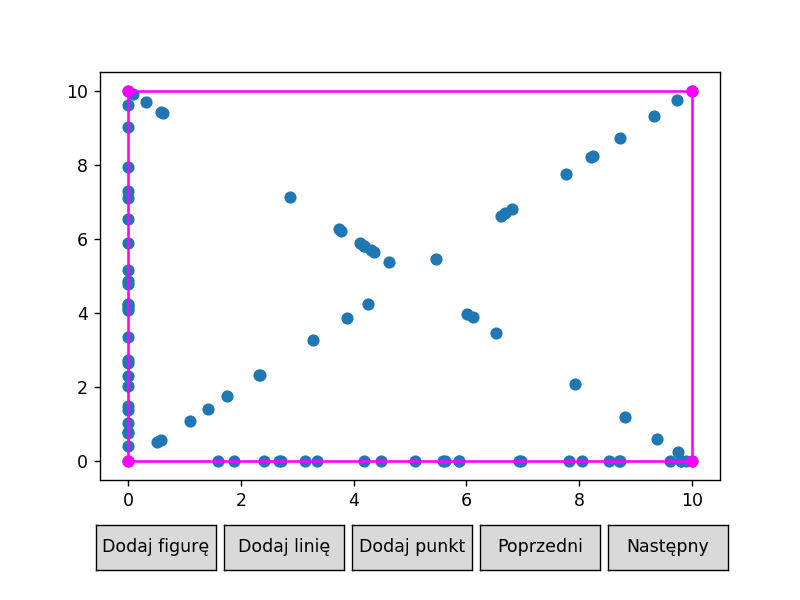

In [25]:
convex_hull_4_jarvis = jarvis_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_jarvis.txt")
plot = Plot(scenes=convex_hull_4_jarvis)
plot.draw()

# Algorytm przyrostowy

In [26]:
def hull_ccw(start_hull, tolerance):
    if len(start_hull) == 3:
        if angle_classification(start_hull[0], start_hull[1], start_hull[2], tolerance) == 1:
            start_hull[1], start_hull[2] = start_hull[2], start_hull[1]
        
    return start_hull

In [27]:
def is_inside(convex_hull, pt, tolerance):
    convex_len = len(convex_hull)
    for i in range(convex_len):
        if angle_classification(convex_hull[i], convex_hull[(i+1)%convex_len], pt, tolerance) == 1:
            return False
    return True

In [28]:
def tangents(hull, pt, tolerance):
    hull_len = len(hull) 
    fst_tgn_idx = 0
    snd_tgn_idx = 0

    old_classify = angle_classification(hull[0], hull[1], pt, tolerance)
    
    idx = 1
    while idx < hull_len:
        new_classify = angle_classification(hull[idx], hull[(idx+1)%hull_len], pt, tolerance)
        if old_classify != 0 and new_classify != old_classify:
            fst_tgn_idx = idx
            old_classify = new_classify
            idx += 1
            break
        old_classify = new_classify
        
        idx += 1
    while idx < hull_len:
        new_classify = angle_classification(hull[idx], hull[(idx + 1)%hull_len], pt, tolerance)
        if old_classify != 0 and new_classify != old_classify:
            snd_tgn_idx = idx
            idx += 1
            break
            
        old_classify = new_classify
        idx += 1

    if angle_classification(hull[fst_tgn_idx], hull[snd_tgn_idx], pt, tolerance) == -1:
        fst_tgn_idx, snd_tgn_idx = snd_tgn_idx, fst_tgn_idx

    return fst_tgn_idx, snd_tgn_idx

In [29]:
def update_hull(fst_tgn_idx, snd_tgn_idx, hull, pt):
    fst_tgn_idx = (fst_tgn_idx+1)%len(hull)
    fst_tgn = hull[fst_tgn_idx]
    
    if fst_tgn_idx != snd_tgn_idx:
        snd_tgn = hull[snd_tgn_idx]
        
        while fst_tgn != snd_tgn:
            hull.pop(fst_tgn_idx)
            if fst_tgn_idx == len(hull):
                fst_tgn_idx = 0
            fst_tgn = hull[fst_tgn_idx]
                
        hull.insert(fst_tgn_idx, pt)
        
    else:
        hull.insert(snd_tgn_idx, pt)
        
    return hull

In [30]:
def generate_scene_incremental(data_set, stack, idx, fst_tgn_idx, snd_tgn_idx, last_scene=False, data_color="blue", 
                   stack_color="magenta", last_pt_color="gold"):
    
    stack_lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    stack_lines.append((stack[-1], stack[0]))
    last_lines = [(stack[fst_tgn_idx], data_set[idx]), (stack[snd_tgn_idx], data_set[idx])]
    
    if last_scene:
        stack_lines.append([stack[-1], stack[0]])
        return Scene([PointsCollection(data_set), 
                      PointsCollection(stack, color=stack_color)], 
                     [LinesCollection(stack_lines, color=stack_color)])
        
    return Scene([PointsCollection(data_set),  
                  PointsCollection([data_set[idx]], color=last_pt_color),
                  PointsCollection(stack.copy(), color=stack_color)],
                 [LinesCollection(last_lines, color=last_pt_color),
                  LinesCollection(stack_lines, color=stack_color)])

In [31]:
def incremental_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_incremental.txt"):
    scenes = []
    set_len = len(data_set)
    
    if set_len < 3:
        return data_set
    
    convex_hull = hull_ccw(data_set[:3], tolerance)
    
    for i in range(3, set_len):
        current_pt = data_set[i]
        
        if not is_inside(convex_hull, current_pt, tolerance):
            fst_tgn_idx, snd_tgn_idx = tangents(convex_hull, current_pt, tolerance)
            new_scene = generate_scene_incremental(data_set, convex_hull, i ,fst_tgn_idx, snd_tgn_idx)
            scenes.append(new_scene)
            convex_hull = update_hull(fst_tgn_idx, snd_tgn_idx, convex_hull, current_pt)
            
            
    last_scene = generate_scene_incremental(data_set, convex_hull, set_len-1, fst_tgn_idx, snd_tgn_idx, last_scene=True)
    scenes.insert(0, last_scene)
    
    if save_results:
        save_file(convex_hull, filename=filename)
    
    return scenes

## Algorytm przyrostowy dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


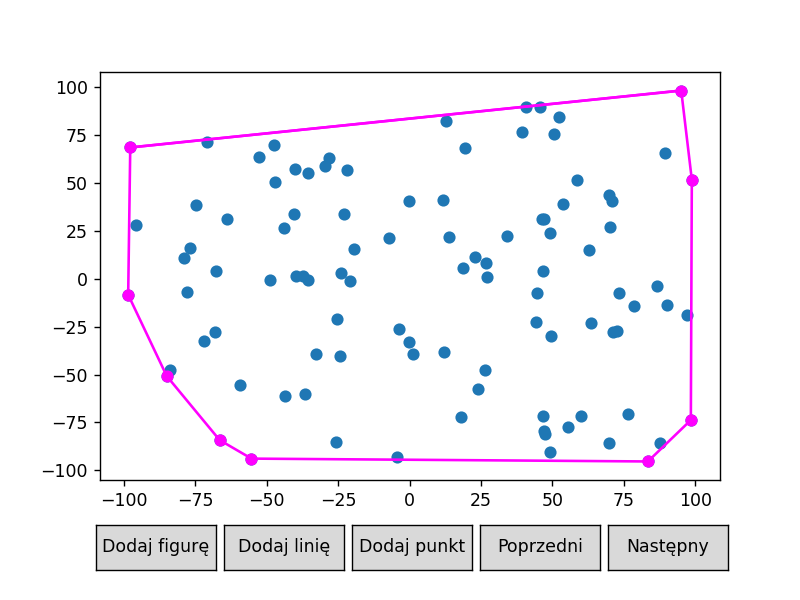

In [32]:
convex_hull_1_incremental = incremental_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_incremental.txt")
plot = Plot(scenes=convex_hull_1_incremental)
plot.draw()

## Algorytm przyrostowy dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


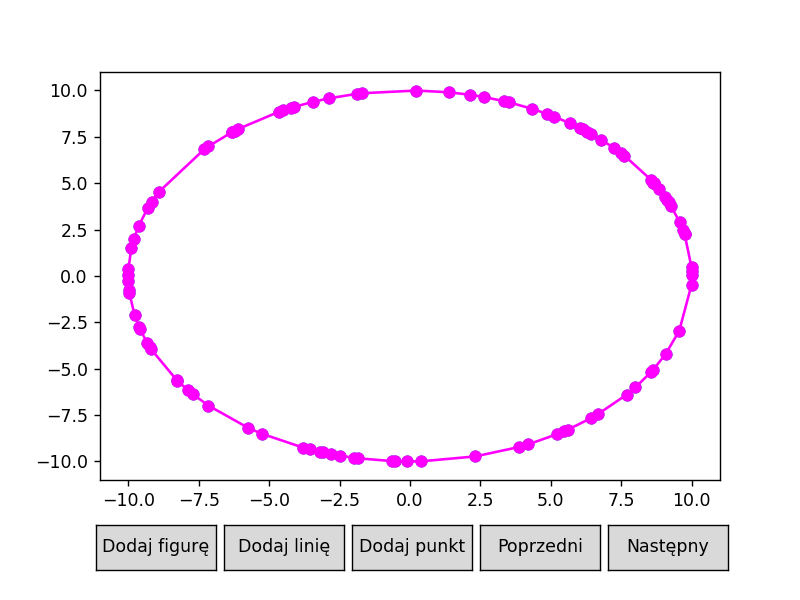

In [33]:
convex_hull_2_incremental = incremental_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_incremental.txt")
plot = Plot(scenes=convex_hull_2_incremental)
plot.draw()

## Algorytm przyrostowy dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


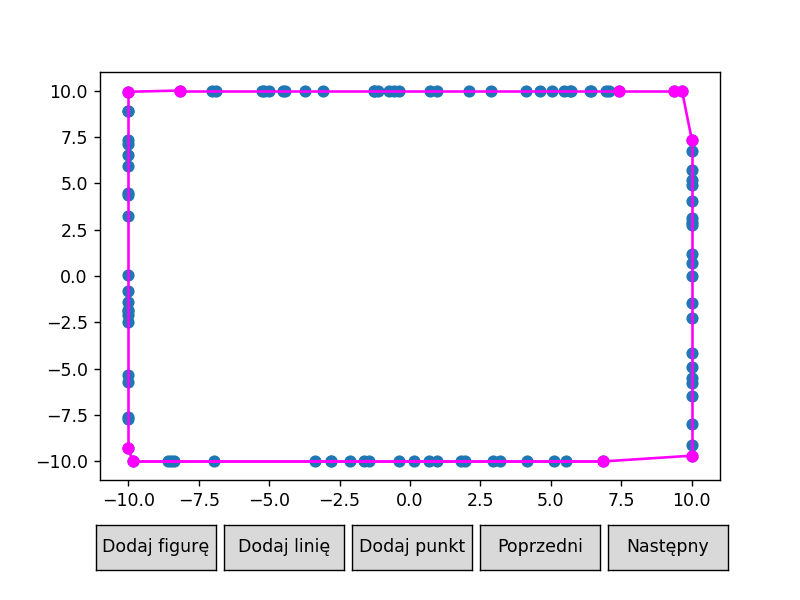

In [34]:
convex_hull_3_incremental = incremental_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_incremental.txt")
plot = Plot(scenes=convex_hull_3_incremental)
plot.draw()

## Algorytm przyrostowy dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


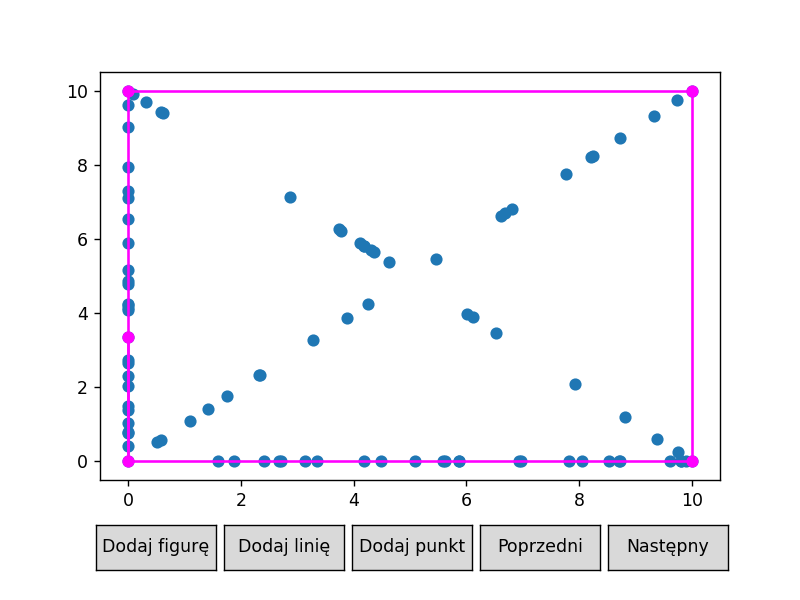

In [35]:
convex_hull_4_incremental = incremental_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_incremental.txt")
plot = Plot(scenes=convex_hull_4_incremental)
plot.draw()

# Algorytm górnej i dolnej otoczki

In [36]:
def generate_scene_upper_lower(data_set, stack, upper_hull, lower_hull, idx, upper=False, lower=False, last_scene=False, 
                               data_color="blue", stack_color="magenta", last_pt_color="gold", upper_hull_color="lime", lower_hull_color="orangered"):
    
    upper_lines = [(upper_hull[i], upper_hull[i+1]) for i in range(len(upper_hull)-1)]
    last_line = [(upper_hull[-2], upper_hull[-1])]
        
    if last_scene:
        stack_lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
        stack_lines.append([stack[-1], stack[0]])
        return Scene([PointsCollection(data_set), 
                      PointsCollection(stack, color=stack_color)], 
                     [LinesCollection(stack_lines, color=stack_color)])
    
    if upper:
        return Scene([PointsCollection(data_set),  
                      PointsCollection([data_set[idx]], color=last_pt_color),
                      PointsCollection(upper_hull[:], color=upper_hull_color)],
                     [LinesCollection(upper_lines, color=upper_hull_color),
                      LinesCollection(last_line, color=last_pt_color)])
    
    if lower:
        lower_lines = [(lower_hull[i], lower_hull[i+1]) for i in range(len(lower_hull)-1)]
        last_line = [(lower_hull[-2], lower_hull[-1])]
        return Scene([PointsCollection(data_set),  
                      PointsCollection([data_set[idx]], color=last_pt_color),
                      PointsCollection(upper_hull, color=upper_hull_color),
                      PointsCollection(lower_hull[:], color=lower_hull_color)],
                     [LinesCollection(upper_lines, color=upper_hull_color),
                      LinesCollection(lower_lines, color=lower_hull_color),
                      LinesCollection(last_line, color=last_pt_color)])

In [37]:
def upper_lower_hull_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_upper_lower.txt"):
    sorted_data = sorted(data_set, key=lambda x: (x[0], x[1]))
    upper_hull = []
    lower_hull = []
    convex_hull = []
    scenes = []
    
    upper_hull.extend(sorted_data[:2])
    for i in range(2, len(sorted_data)):
        upper_hull.append(sorted_data[i])
        new_scene = generate_scene_upper_lower(sorted_data, convex_hull, upper_hull, lower_hull, i , upper=True)
        scenes.append(new_scene)
        while len(upper_hull) > 2 and angle_classification(upper_hull[-3], upper_hull[-2], upper_hull[-1], tolerance) < 1:
            upper_hull.pop(-2)
            new_scene = generate_scene_upper_lower(sorted_data, convex_hull, upper_hull, lower_hull, i , upper=True)
            scenes.append(new_scene)
            
    lower_hull.extend(sorted_data[:2])
    for i in range(2, len(sorted_data)):
        lower_hull.append(sorted_data[i])
        new_scene = generate_scene_upper_lower(sorted_data, convex_hull, upper_hull, lower_hull, i , lower=True)
        scenes.append(new_scene)
        while len(lower_hull) > 2 and angle_classification(lower_hull[-3], lower_hull[-2], lower_hull[-1], tolerance) > -1:
            lower_hull.pop(-2)
            new_scene = generate_scene_upper_lower(sorted_data, convex_hull, upper_hull, lower_hull, i , lower=True)
            scenes.append(new_scene)
    
    lower_hull.reverse()
    upper_hull.pop()
    lower_hull.pop()
    convex_hull = upper_hull + lower_hull
    
    last_scene = generate_scene_upper_lower(sorted_data, convex_hull, upper_hull, lower_hull, len(convex_hull)-1, last_scene=True)
    scenes.insert(0, last_scene)
    
    if save_results:
        save_file(convex_hull, filename=filename)
        
    return scenes

## Algorytm górnej i dolnej otoczki dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


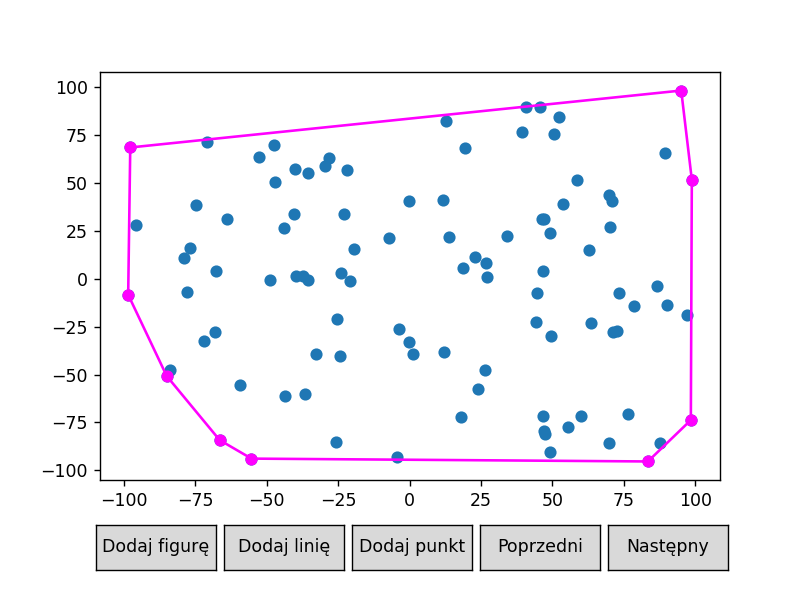

In [38]:
convex_hull_1_upper_lower = upper_lower_hull_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_upper_lower.txt")
plot = Plot(scenes=convex_hull_1_upper_lower)
plot.draw()

## Algorytm górnej i dolnej otoczki dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


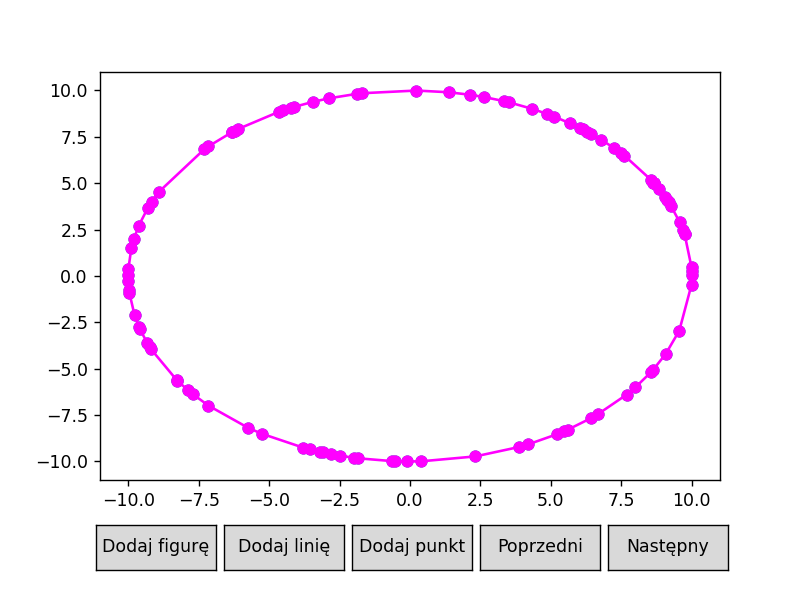

In [39]:
convex_hull_2_upper_lower = upper_lower_hull_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_upper_lower.txt")
plot = Plot(scenes=convex_hull_2_upper_lower)
plot.draw()

## Algorytm górnej i dolnej otoczki dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


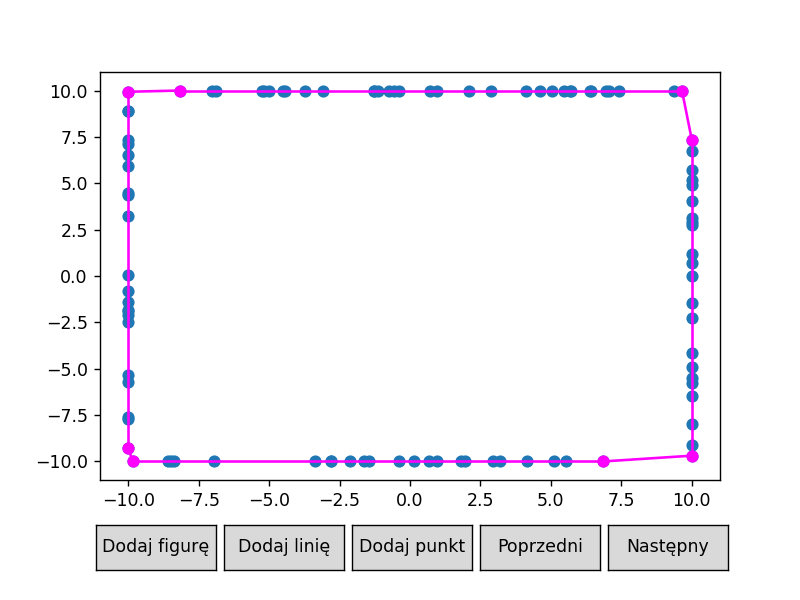

In [40]:
convex_hull_3_upper_lower = upper_lower_hull_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_upper_lower.txt")
plot = Plot(scenes=convex_hull_3_upper_lower)
plot.draw()

## Algorytm górnej i dolnej otoczki dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


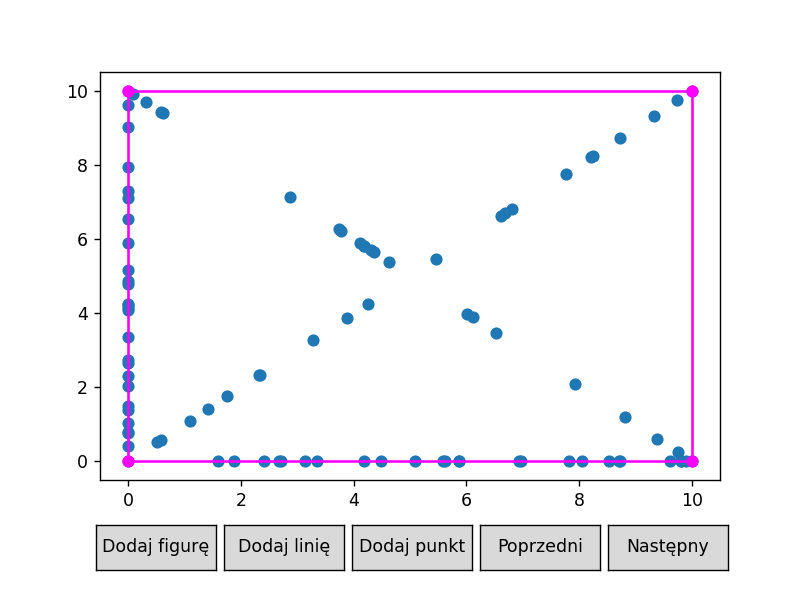

In [41]:
convex_hull_4_upper_lower = upper_lower_hull_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_upper_lower.txt")
plot = Plot(scenes=convex_hull_4_upper_lower)
plot.draw()

# Algorytm Quick Hull

In [42]:
def quick_hull_recursion(data_set, pt_a, pt_b, subset, scenes, tolerance=10e-12):
    
    if not subset:
        return 
    
    if len(subset) == 1:
        return [subset[0]]
    
    hull = []
    subset_1 = []
    subset_2 = []
    
    pt_c = max(subset, key = lambda x: distance_to_line(x, pt_a, pt_b))
    
    for pt in subset: 
        if angle_classification(pt_a, pt_c, pt, tolerance) == 1:
            subset_1.append(pt)
        if angle_classification(pt_c, pt_b, pt, tolerance) == 1:
            subset_2.append(pt)
            
    current_hull = [pt_a, pt_b, pt_c]
    current_hull_lines = [[pt_a, pt_b], [pt_a, pt_c], [pt_b, pt_c]]  
    new_scene = Scene([PointsCollection(data_set),
                       PointsCollection(subset, color="white"),
                       PointsCollection(subset_1, color="orange"),
                       PointsCollection(subset_2, color="black"),
                       PointsCollection(current_hull, color="magenta")],
                      [LinesCollection(current_hull_lines, color="magenta")])
    scenes.append(new_scene)
    
    hull_1 = quick_hull_recursion(data_set, pt_a, pt_c, subset_1, scenes)
    
    if hull_1:
        hull.extend(hull_1)
        
    hull.append(pt_c)
    hull_2 = quick_hull_recursion(data_set, pt_c, pt_b, subset_2, scenes)
    
    if hull_2:
        hull.extend(hull_2)
    
    return hull

In [43]:
def quick_hull_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_quick_hull.txt"):
    scenes = []
    hull = []
    subset_1 = []
    subset_2 = []
    
    pt_a = min(data_set, key = lambda x: (x[0], x[1]))
    pt_b = max(data_set, key = lambda x: (x[0], x[1]))
    
    for pt in data_set:
        if angle_classification(pt_a, pt_b, pt, tolerance) == 1:
            subset_1.append(pt)
        if angle_classification(pt_a, pt_b, pt, tolerance) == -1:
            subset_2.append(pt)
            
    hull.append(pt_a)
    hull_1 = quick_hull_recursion(data_set, pt_a, pt_b, subset_1, scenes)
    
    if hull_1:
        hull.extend(hull_1)
        
    hull.append(pt_b)
    hull_2 = quick_hull_recursion(data_set, pt_b, pt_a, subset_2, scenes)
    
    if hull_2:
        hull.extend(hull_2)

    hull_lines = [(hull[i], hull[(i+1)%len(hull)]) for i in range(len(hull))]
    last_scene = Scene([PointsCollection(data_set),
                        PointsCollection(hull, color="magenta")],
                       [LinesCollection(hull_lines, color="magenta")])
    scenes.insert(0, last_scene)
    
    if save_results:
        hull = [list(h) for h in set(tuple(h) for h in hull)]
        save_file(hull, filename=filename)

    return scenes

## Algorytm Quick Hull dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


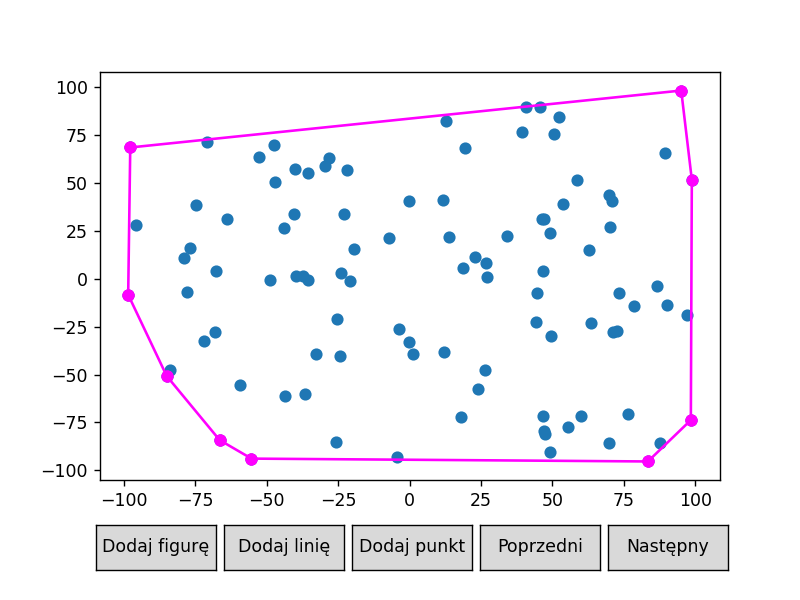

In [44]:
convex_hull_1_quick_hull = quick_hull_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_quick_hull.txt")
plot = Plot(scenes=convex_hull_1_quick_hull)
plot.draw()

## Algorytm Quick Hull dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


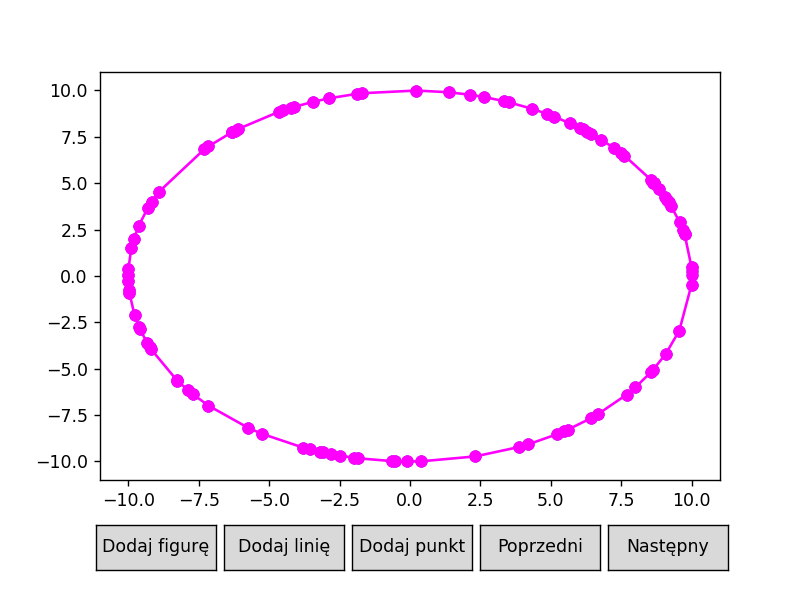

In [45]:
convex_hull_2_quick_hull = quick_hull_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_quick_hull.txt")
plot = Plot(scenes=convex_hull_2_quick_hull)
plot.draw()

## Algorytm Quick Hull dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


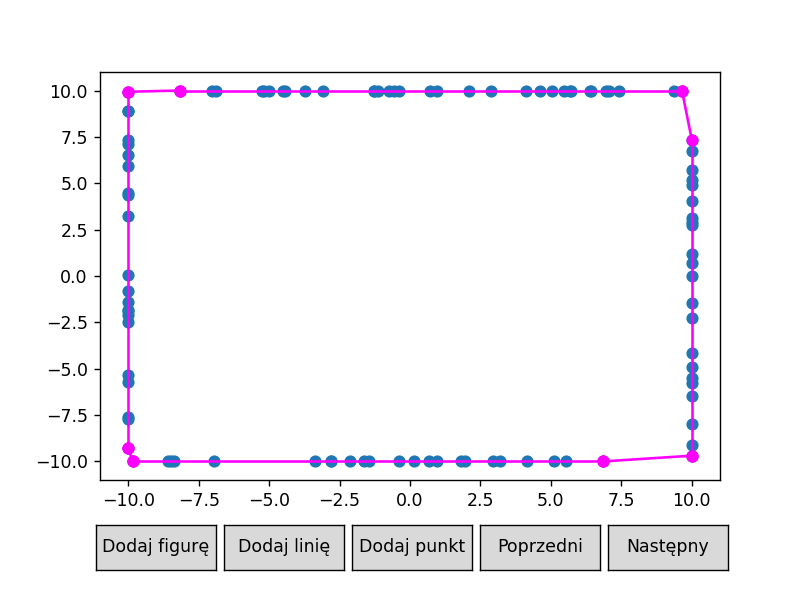

In [46]:
convex_hull_3_quick_hull = quick_hull_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_quick_hull.txt")
plot = Plot(scenes=convex_hull_3_quick_hull)
plot.draw()

## Algorytm Quick Hull dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


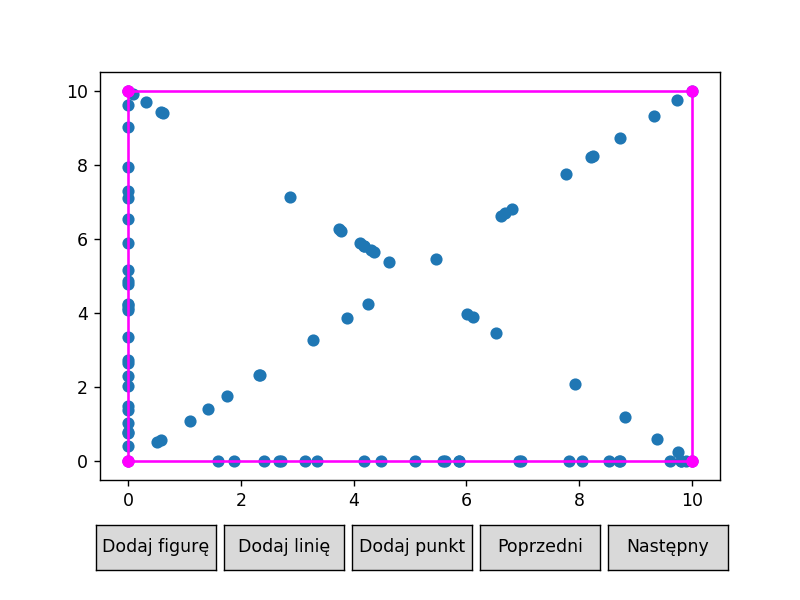

In [47]:
convex_hull_4_quick_hull = quick_hull_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_quick_hull.txt")
plot = Plot(scenes=convex_hull_4_quick_hull)
plot.draw()

# Algorytm dziel i rządź

In [48]:
def generate_scene_divide_and_conquer(data_set, hull, current_lines=[]):
    if current_lines != []:
        return Scene([PointsCollection(data_set)]+
                     [PointsCollection(i.copy(), color="magenta") for i in hull]+
                     [PointsCollection([current_lines[0][0],current_lines[0][1],current_lines[1][0],current_lines[1][1]], color="gold")],
                     [LinesCollection(current_lines.copy(), color="gold")]+
                     [LinesCollection([(i[j], i[j+1]) for j in range(len(i)-1)], color="magenta") for i in hull])
    else:
        return Scene([PointsCollection(data_set)]+
                     [PointsCollection(i.copy(), color="magenta") for i in hull],
                     [LinesCollection([(i[j], i[j+1]) for j in range(len(i)-1)], color="magenta") for i in hull])

In [49]:
def divide_and_conquer_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_divide_and_conquer.txt"):
    hull=[]
    scenes=[]
    
    def divide_and_conquer_algorithm_rek(l,r):
        if r-l==1:
            hull.append([data_set[l]])
            scenes.append(generate_scene_divide_and_conquer(data_set,hull))
            return [data_set[l]]
        if r-l==2:
            hull.append([data_set[l],data_set[l+1],data_set[l]])
            scenes.append(generate_scene_divide_and_conquer(data_set,hull))
            return [data_set[l],data_set[l+1]]
        
        x=(l+r)//2
        hull1=divide_and_conquer_algorithm_rek(l,x)
        hull2=divide_and_conquer_algorithm_rek(x,r)
        a=hull1.index(max(hull1))
        b=hull2.index(min(hull2))
        c=a
        d=b
        
        if len(hull1)==1:
            while (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==1
                or (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==0
                    and dist(hull1[a],hull2[b])<dist(hull1[a],hull2[b-1]))):
                scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
                b=(b-1)%len(hull2)
            while (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==-1
                or (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==0
                    and dist(hull1[c],hull2[d])<dist(hull1[c],hull2[(d+1)%len(hull2)]))):
                scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
                d=(d+1)%len(hull2)
        else:
            while ((angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==1
                   or (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==0
                       and dist(hull1[a],hull2[b])<dist(hull1[a],hull2[b-1])))
                or (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==1
                    or (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==0
                        and dist(hull2[b],hull1[a])<dist(hull2[b],hull1[(a+1)%len(hull1)])))):
                while (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==1
                    or (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==0
                        and dist(hull1[a],hull2[b])<dist(hull1[a],hull2[b-1]))):
                    scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
                    b=(b-1)%len(hull2)
                while (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==1
                    or (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==0
                        and dist(hull2[b],hull1[a])<dist(hull2[b],hull1[(a+1)%len(hull1)]))):
                    scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
                    a=(a+1)%len(hull1)
            while ((angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==-1
                   or (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==0
                       and dist(hull1[c],hull2[d])<dist(hull1[c],hull2[(d+1)%len(hull2)])))
                or (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==-1
                    or (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==0
                        and dist(hull2[d],hull1[c])<dist(hull2[d],hull1[c-1])))):
                while (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==-1
                    or (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==0
                        and dist(hull1[c],hull2[d])<dist(hull1[c],hull2[(d+1)%len(hull2)]))):
                    scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
                    d=(d+1)%len(hull2)
                while (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==-1
                    or (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==0
                        and dist(hull2[d],hull1[c])<dist(hull2[d],hull1[c-1]))):
                    scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
                    c=(c-1)%len(hull1)
                    
        scenes.append(generate_scene_divide_and_conquer(data_set,hull,[[hull1[a],hull2[b]],[hull1[c],hull2[d]]]))
        
        hull.pop()
        hull.pop()
        stack=[]
        
        while True:
            stack.append(hull1[a])
            if a==c:
                break
            a=(a+1)%len(hull1)
            
        while True:
            stack.append(hull2[d])
            if d==b:
                break
            d=(d+1)%len(hull2)
        hull.append(stack+[stack[0]])
        scenes.append(generate_scene_divide_and_conquer(data_set,hull))
        return stack
    
    data_set.sort()
    stack=divide_and_conquer_algorithm_rek(0,len(data_set))
    stack_lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    stack_lines.append([stack[-1], stack[0]])
    scene=Scene([PointsCollection(data_set), PointsCollection(stack, color="magenta")], [LinesCollection(stack_lines, color="magenta")])
    scenes.insert(0,scene)
    
    if save_results:
        save_file(*hull, filename=filename)
    
    return scenes

## Algorytm dziel i rządź dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


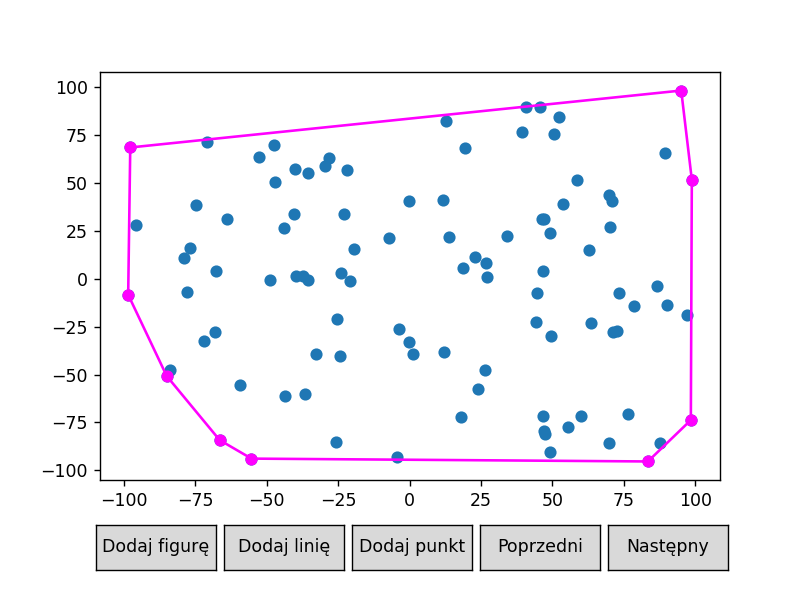

In [50]:
convex_hull_1_divide_and_conquer = divide_and_conquer_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_divide_and_conquer.txt")
plot = Plot(scenes=convex_hull_1_divide_and_conquer)
plot.draw()

## Algorytm dziel i rządź dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


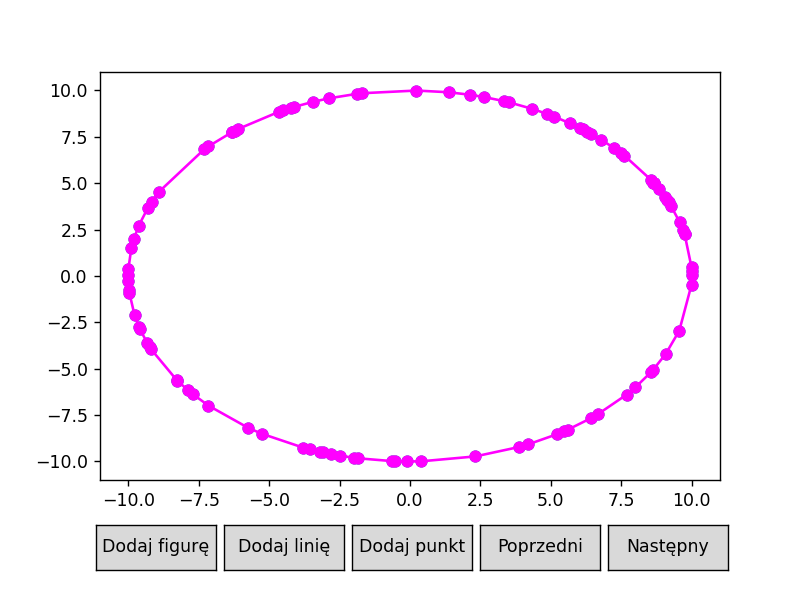

In [51]:
convex_hull_2_divide_and_conquer = divide_and_conquer_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_divide_and_conquer.txt")
plot = Plot(scenes=convex_hull_2_divide_and_conquer)
plot.draw()

## Algorytm dziel i rządź dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


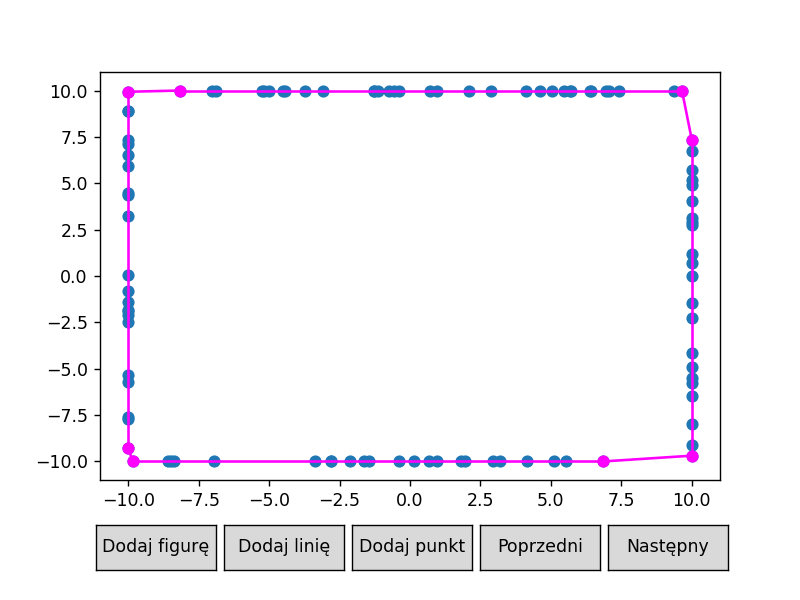

In [52]:
convex_hull_3_divide_and_conquer = divide_and_conquer_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_divide_and_conquer.txt")
plot = Plot(scenes=convex_hull_3_divide_and_conquer)
plot.draw()

## Algorytm dziel i rządź dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


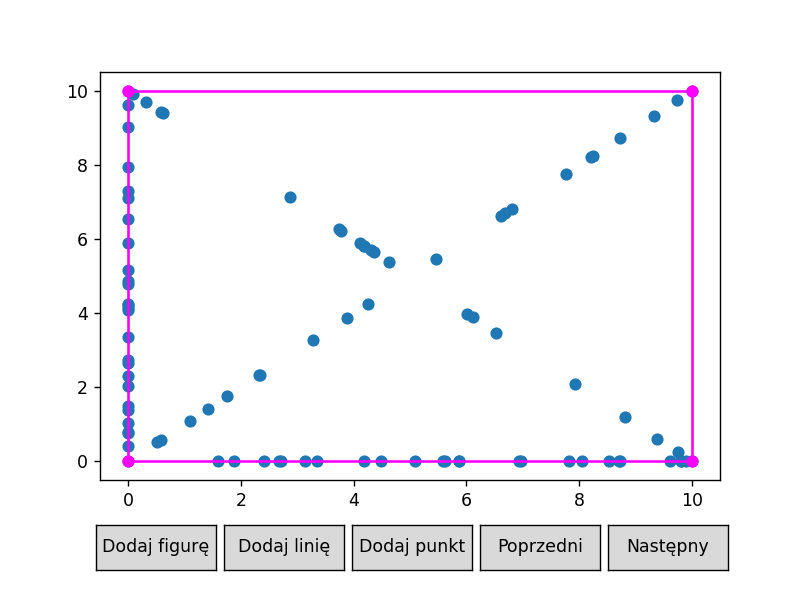

In [53]:
convex_hull_4_divide_and_conquer = divide_and_conquer_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_divide_and_conquer.txt")
plot = Plot(scenes=convex_hull_4_divide_and_conquer)
plot.draw()

# Algorytm Chan'a

In [54]:
def generate_scene_chan(data_set,hull,stack,last):
    return Scene([PointsCollection(data_set)]+
                 [PointsCollection(i.copy(), color="lime") for i in hull]+
                 [PointsCollection([last], color="gold"),
                  PointsCollection(stack.copy(), color="magenta")],
                 [LinesCollection([(i[j], i[j+1]) for j in range(len(i)-1)], color="lime") for i in hull]+
                 [LinesCollection([(last,stack[-1])], color="gold"),
                  LinesCollection([[stack[i], stack[i+1]] for i in range(len(stack)-1)], color="magenta")])

In [55]:
def graham_to_chan_algorithm(data_set, tolerance=10e-12):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    sorted_data = sorted(data_set, key=compare(lambda x, y: angle_classification(min_pt, x, y, tolerance)))
    sorted_data, removed_data = remove_collinear(sorted_data, min_pt, tolerance)
    
    stack = []
    stack.extend(sorted_data[:3])
    idx = len(stack)
    
    while idx < len(sorted_data):
        pt_a, pt_b = stack[-2], stack[-1]
        pt_next = sorted_data[idx]
        
        if angle_orientation(pt_a, pt_b, pt_next) == -1:
            stack.append(pt_next)
            idx += 1
        else:
            stack.pop()
    return stack

In [56]:
def min_angle(pt_stack, pt_last, pt_next, tolerance=10e-12):
    if pt_stack == pt_last:
        return pt_next
    elif angle_orientation(pt_stack, pt_last, pt_next) == 1:
        return pt_next
    elif (angle_orientation(pt_stack, pt_last, pt_next) == 0 
        and dist(pt_stack, pt_next) > dist(pt_stack, pt_last)):
        return pt_next
    else:
        return pt_last

In [57]:
def search(hull,hull_index,i,b,pt,tolerance=10e-12):
    if b==-1:
        min_pt=min(hull,key=lambda x: dist(x,pt))
        b=hull.index(min_pt)
    while (angle_classification(hull[b],hull[(b+1)%len(hull)],pt,tolerance)==1
        or (angle_classification(hull[b],hull[(b+1)%len(hull)],pt,tolerance)==0
            and dist(pt,hull[b])<dist(pt,hull[(b+1)%len(hull)]))):
        b=(b+1)%len(hull)
    hull_index[i]=b
    return hull[b]

In [58]:
def chan_partial_algorithm(data_set, h, tolerance=10e-12):
    scenes=[]
    hull=[]
    hull_index=[]
    k=0
    while k<len(data_set):
        hull.append(graham_to_chan_algorithm(data_set[k:min(k+h,len(data_set))]))
        hull_index.append(-1)
        k+=h
    hulls=[]
    for i in hull:
        hulls.append(i.copy())
        hulls[-1].append(hulls[-1][0])
    scenes.append(Scene([PointsCollection(data_set)]+
                       [PointsCollection(i.copy(), color="lime") for i in hulls],
                       [LinesCollection([(i[j], i[j+1]) for j in range(len(i)-1)], color="lime") for i in hulls]))
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    stack = []
    pt_stack = min_pt
    for i in range(h):
        stack.append(pt_stack)
        pt_last = data_set[0]
        for i in range(len(hull)):
            idx=search(hull[i],hull_index,i,hull_index[i],stack[-1])
            new_scene = generate_scene_chan(data_set, hulls, stack, idx)
            scenes.append(new_scene)
            pt_last = min_angle(pt_stack, pt_last, idx)
        pt_stack = pt_last
        if pt_stack == min_pt:
            break
    
    if pt_stack == min_pt:
        return scenes,stack
    else:
        return scenes,None

In [59]:
def chan_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_chan.txt"):
    scenes=[]
    t=1
    while True:
        scene,stack=chan_partial_algorithm(data_set,min(len(data_set),2**(2**t)))
        scenes+=scene
        if stack!=None:
            stack_lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
            stack_lines.append([stack[-1], stack[0]])
            scene=Scene([PointsCollection(data_set), PointsCollection(stack, color="magenta")], [LinesCollection(stack_lines, color="magenta")])
            scenes.insert(0,scene)
            
            if save_results:
                save_file(stack, filename=filename)
            
            return scenes
        t+=1

## Algorytm Chan'a dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


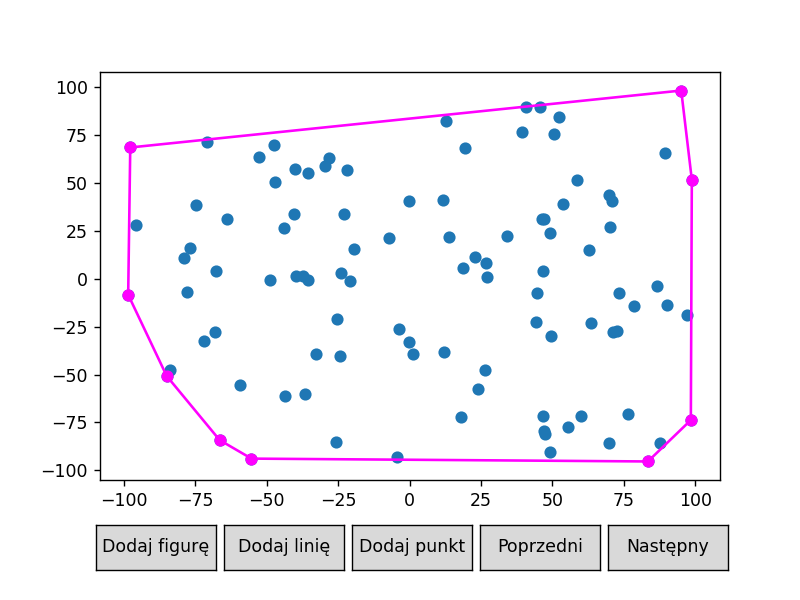

In [60]:
convex_hull_1_chan = chan_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_chan.txt")
plot = Plot(scenes=convex_hull_1_chan)
plot.draw()

## Algorytm Chan'a dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


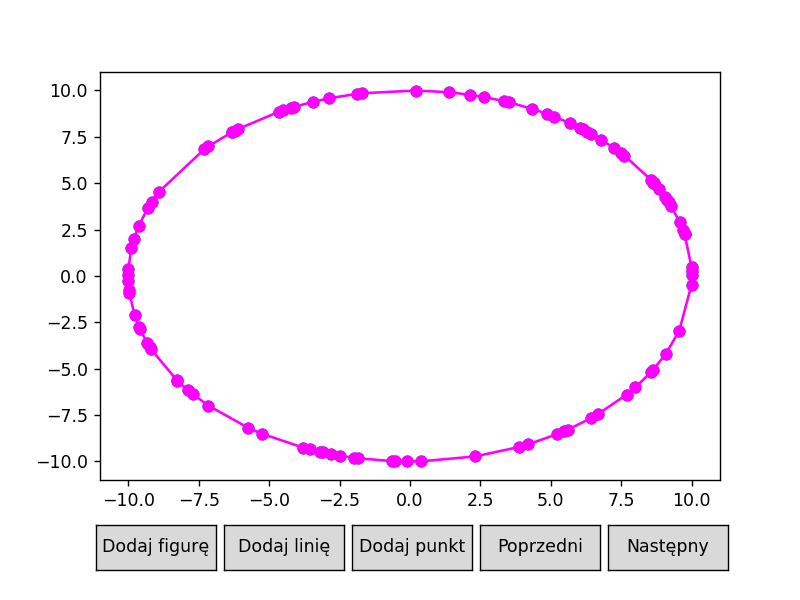

In [61]:
convex_hull_2_chan = chan_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_chan.txt")
plot = Plot(scenes=convex_hull_2_chan)
plot.draw()

## Algorytm Chan'a dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


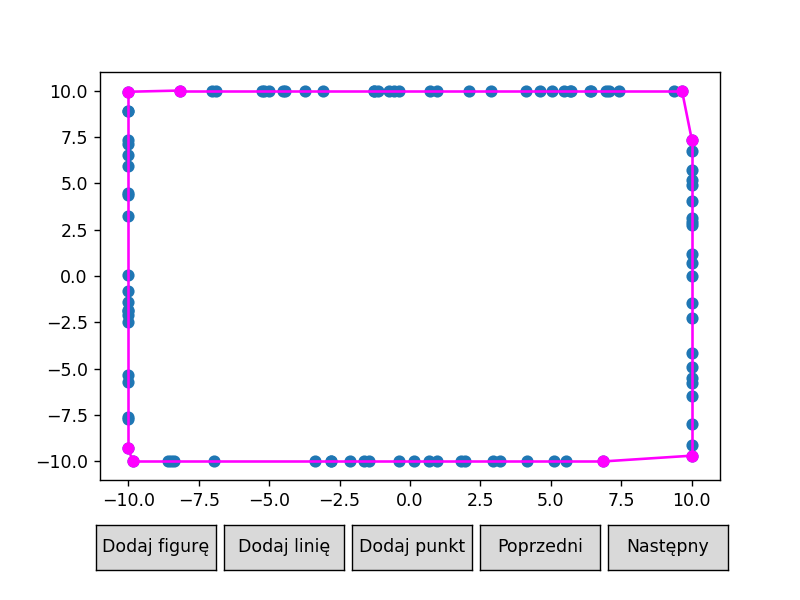

In [62]:
convex_hull_3_chan = chan_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_chan.txt")
plot = Plot(scenes=convex_hull_3_chan)
plot.draw()

## Algorytm Chan'a dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


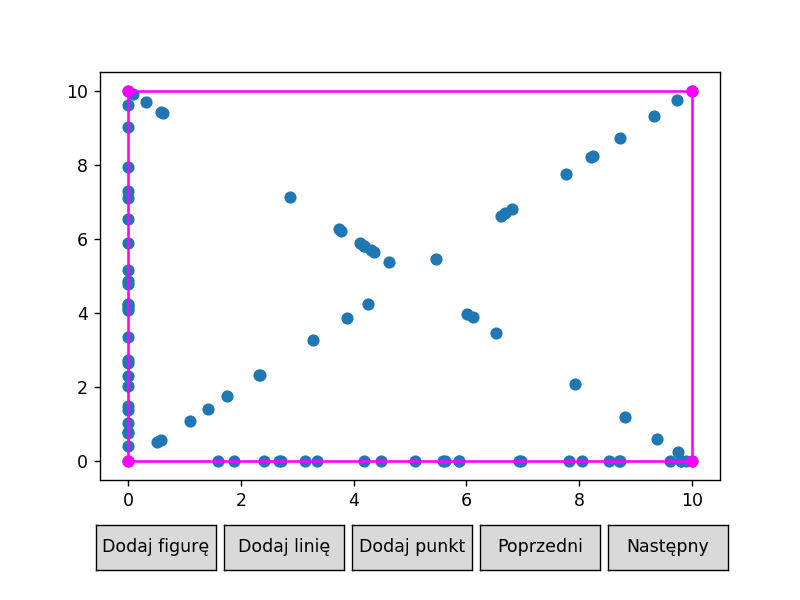

In [63]:
convex_hull_4_chan = chan_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_chan.txt")
plot = Plot(scenes=convex_hull_4_chan)
plot.draw()

## Wprowadzanie danych na wykresie przez użytkownika (przykład poniżej)

## Algorytm Chan'a dla zbioru danych zdefiniowanego przez użytkownika

In [64]:
def to_points(plot):
    points=plot.get_added_points()[-1].points
    return points

#### Wprowadzanie punktów na wykresie

<IPython.core.display.Javascript object>


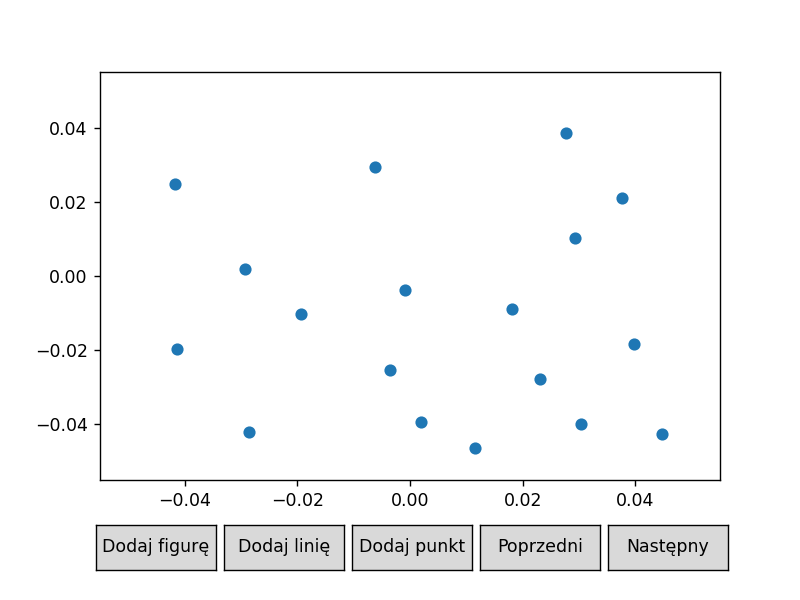

In [65]:
plot1=Plot(scenes=[Scene()])
plot1.draw()

#### Wynik algorytmu

In [66]:
data_set_5=to_points(plot1)

<IPython.core.display.Javascript object>


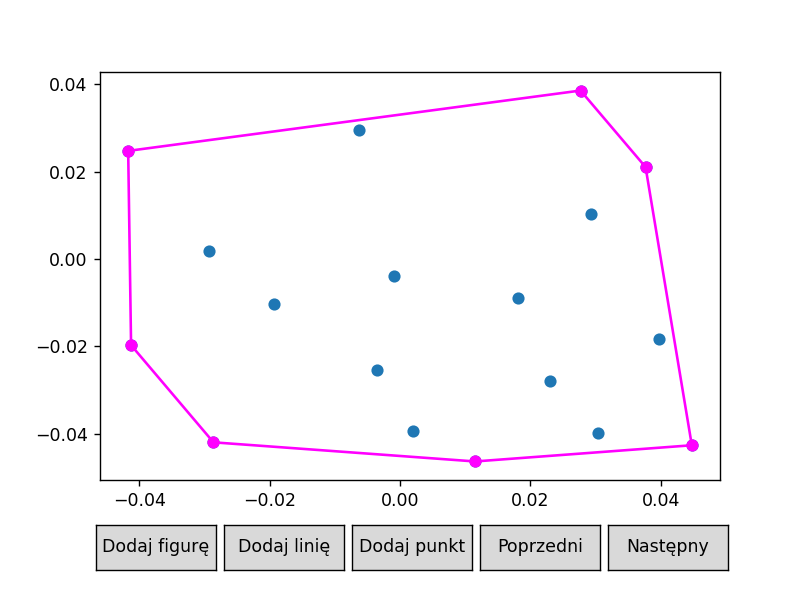

In [67]:
convex_hull_5 = chan_algorithm(data_set_5)
plot = Plot(scenes=convex_hull_5)
plot.draw()

# Testy czasowe

In [68]:
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns

In [69]:
def graham_algorithm_tst(data_set, tolerance=10e-12):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    sorted_data = sorted(data_set, key=compare(lambda x, y: angle_classification(min_pt, x, y, tolerance)))
    sorted_data, removed_data = remove_collinear(sorted_data, min_pt, tolerance)
    
    stack = []
    stack.extend(sorted_data[:3])
    idx = len(stack)
    
    while idx < len(sorted_data):
        pt_a, pt_b = stack[-2], stack[-1]
        pt_next = sorted_data[idx]
        
        if angle_orientation(pt_a, pt_b, pt_next) == -1:
            stack.append(pt_next)
            idx += 1
        else:
            stack.pop()
    
    if angle_orientation(pt_a, pt_b, min_pt) == 0:
        stack.pop()
        
    return stack

In [70]:
def jarvis_algorithm_tst(data_set, tolerance=10e-12):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    stack = []
    pt_stack = min_pt
    
    while True:
        stack.append(pt_stack)
        pt_last = data_set[0]
        
        for idx in range(len(data_set)):
            pt_last = min_angle(pt_stack, pt_last, data_set[idx])
        
        pt_stack = pt_last
        if pt_stack == min_pt:
            break
    
    return stack

In [71]:
def incremental_algorithm_tst(data_set, tolerance=10e-12):
    set_len = len(data_set)
    
    if set_len < 3:
        return data_set
    
    convex_hull = hull_ccw(data_set[:3], tolerance)
    
    for i in range(3, set_len):
        current_pt = data_set[i]
        
        if not is_inside(convex_hull, current_pt, tolerance):
            fst_tgn_idx, snd_tgn_idx = tangents(convex_hull, current_pt, tolerance)
            convex_hull = update_hull(fst_tgn_idx, snd_tgn_idx, convex_hull, current_pt)
    
    return convex_hull

In [72]:
def upper_lower_hull_algorithm_tst(data_set, tolerance=10e-12):
    sorted_data = sorted(data_set, key=lambda x: (x[0], x[1]))
    upper_hull = []
    lower_hull = []
    convex_hull = []
    
    upper_hull.extend(sorted_data[:2])
    for i in range(2, len(sorted_data)):
        upper_hull.append(sorted_data[i])
        while len(upper_hull) > 2 and angle_classification(upper_hull[-3], upper_hull[-2], upper_hull[-1], tolerance) < 1:
            upper_hull.pop(-2)
            
    lower_hull.extend(sorted_data[:2])
    for i in range(2, len(sorted_data)):
        lower_hull.append(sorted_data[i])
        while len(lower_hull) > 2 and angle_classification(lower_hull[-3], lower_hull[-2], lower_hull[-1], tolerance) > -1:
            lower_hull.pop(-2)
    
    lower_hull.reverse()
    upper_hull.pop()
    lower_hull.pop()
    convex_hull = upper_hull + lower_hull
        
    return convex_hull

In [73]:
def quick_hull_recursion_tst(data_set, pt_a, pt_b, subset, tolerance=10e-12):
    
    if not subset:
        return 
    
    if len(subset) == 1:
        return [subset[0]]
    
    hull = []
    subset_1 = []
    subset_2 = []
    
    pt_c = max(subset, key = lambda x: distance_to_line(x, pt_a, pt_b))
    
    for pt in subset: 
        if angle_classification(pt_a, pt_c, pt, tolerance) == 1:
            subset_1.append(pt)
        if angle_classification(pt_c, pt_b, pt, tolerance) == 1:
            subset_2.append(pt)  
    
    hull_1 = quick_hull_recursion_tst(data_set, pt_a, pt_c, subset_1)
    
    if hull_1:
        hull.extend(hull_1)
        
    hull.append(pt_c)
    hull_2 = quick_hull_recursion_tst(data_set, pt_c, pt_b, subset_2)
    
    if hull_2:
        hull.extend(hull_2)
    
    return hull


def quick_hull_algorithm_tst(data_set, tolerance=10e-12):
    hull = []
    subset_1 = []
    subset_2 = []
    
    pt_a = min(data_set, key = lambda x: (x[0], x[1]))
    pt_b = max(data_set, key = lambda x: (x[0], x[1]))
    
    for pt in data_set:
        if angle_classification(pt_a, pt_b, pt, tolerance) == 1:
            subset_1.append(pt)
        if angle_classification(pt_a, pt_b, pt, tolerance) == -1:
            subset_2.append(pt)
            
    hull.append(pt_a)
    hull_1 = quick_hull_recursion_tst(data_set, pt_a, pt_b, subset_1)
    
    if hull_1:
        hull.extend(hull_1)
        
    hull.append(pt_b)
    hull_2 = quick_hull_recursion_tst(data_set, pt_b, pt_a, subset_2)
    
    if hull_2:
        hull.extend(hull_2)

    return hull

In [74]:
def divide_and_conquer_algorithm_tst(data_set, tolerance=10e-12):
    def divide_and_conquer_algorithm_rek_tst(l,r):
        if r-l==1:
            return [data_set[l]]
        if r-l==2:
            return [data_set[l],data_set[l+1]]
        x=(l+r)//2
        hull1=divide_and_conquer_algorithm_rek_tst(l,x)
        hull2=divide_and_conquer_algorithm_rek_tst(x,r)
        a=hull1.index(max(hull1))
        b=hull2.index(min(hull2))
        c=a
        d=b
        if len(hull1)==1:
            while (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==1
                or (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==0
                    and dist(hull1[a],hull2[b])<dist(hull1[a],hull2[b-1]))):
                b=(b-1)%len(hull2)
            while (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==-1
                or (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==0
                    and dist(hull1[c],hull2[d])<dist(hull1[c],hull2[(d+1)%len(hull2)]))):
                d=(d+1)%len(hull2)
        else:
            while ((angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==1
                   or (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==0
                       and dist(hull1[a],hull2[b])<dist(hull1[a],hull2[b-1])))
                or (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==1
                    or (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==0
                        and dist(hull2[b],hull1[a])<dist(hull2[b],hull1[(a+1)%len(hull1)])))):
                while (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==1
                    or (angle_classification(hull2[b],hull2[b-1],hull1[a],tolerance)==0
                        and dist(hull1[a],hull2[b])<dist(hull1[a],hull2[b-1]))):
                    b=(b-1)%len(hull2)
                while (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==1
                    or (angle_classification(hull1[a],hull2[b],hull1[(a+1)%len(hull1)],tolerance)==0
                        and dist(hull2[b],hull1[a])<dist(hull2[b],hull1[(a+1)%len(hull1)]))):
                    a=(a+1)%len(hull1)
            while ((angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==-1
                   or (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==0
                       and dist(hull1[c],hull2[d])<dist(hull1[c],hull2[(d+1)%len(hull2)])))
                or (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==-1
                    or (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==0
                        and dist(hull2[d],hull1[c])<dist(hull2[d],hull1[c-1])))):
                while (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==-1
                    or (angle_classification(hull2[d],hull2[(d+1)%len(hull2)],hull1[c],tolerance)==0
                        and dist(hull1[c],hull2[d])<dist(hull1[c],hull2[(d+1)%len(hull2)]))):
                    d=(d+1)%len(hull2)
                while (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==-1
                    or (angle_classification(hull1[c],hull2[d],hull1[c-1],tolerance)==0
                        and dist(hull2[d],hull1[c])<dist(hull2[d],hull1[c-1]))):
                    c=(c-1)%len(hull1)
        stack=[]
        while True:
            stack.append(hull1[a])
            if a==c:
                break
            a=(a+1)%len(hull1)
        while True:
            stack.append(hull2[d])
            if d==b:
                break
            d=(d+1)%len(hull2)
        return stack
    
    data_set.sort()
    stack=divide_and_conquer_algorithm_rek_tst(0,len(data_set))
    
    return stack

In [75]:
def chan_partial_algorithm_tst(data_set, h, tolerance=10e-12):
    hull=[]
    hull_index=[]
    k=0
    while k<len(data_set):
        hull.append(graham_to_chan_algorithm(data_set[k:min(k+h,len(data_set))]))
        hull_index.append(-1)
        k+=h
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    stack = []
    pt_stack = min_pt
    for i in range(h):
        stack.append(pt_stack)
        pt_last = data_set[0]
        for i in range(len(hull)):
            idx=search(hull[i],hull_index,i,hull_index[i],stack[-1])
            pt_last = min_angle(pt_stack, pt_last, idx)
        pt_stack = pt_last
        if pt_stack == min_pt:
            break
    
    if pt_stack == min_pt:
        return stack
    else:
        return None

    
def chan_algorithm_tst(data_set, tolerance=10e-12):
    scenes=[]
    t=1
    while True:
        stack=chan_partial_algorithm_tst(data_set,min(len(data_set),2**(2**t)))
        if stack!=None:
            return stack
        t+=1

In [76]:
def performance_test(set_generator, set_num, num_points):
    
    if set_num == 1:
        sets = list(map(lambda x: set_generator(x, (-100, 100)), num_points))
    elif set_num == 2:
        sets = list(map(lambda x: set_generator(x, (0, 0), 10), num_points))
    elif set_num == 3:
        sets = list(map(lambda x: set_generator(x, [(-10, 10), (-10, -10), (10, -10), (10, 10)]), num_points))
    elif set_num == 4:
        sets = list(map(lambda x: set_generator(x//4-1, x//4-1, [(0, 0), (0, 10), (10, 0), (10, 10)]), num_points))
        
    results = []
    names = ["Ilość punktów", "Algorytm Grahama [sek]", "Algorytm Jarvisa [sek]", 
             "Algorytm Przyrostowy [sek]", "Algorytm Górnej i Dolnej Otoczki [sek]",
             "Algorytm Quick Hull [sek]", "Algorytm Dziel i Rządź [sek]", "Algorytm Chana [sek]"]
    
    ind = 0
    for d_set in sets:
        set_len = len(d_set)
        
        start = timer()
        graham_algorithm_tst(d_set.tolist())
        end = timer()
        graham_time = round(end-start, 5)
        
        start = timer()
        jarvis_algorithm_tst(d_set.tolist())
        end = timer()
        jarvis_time = round(end-start, 5)
        
        start = timer()
        incremental_algorithm_tst(d_set.tolist())
        end = timer()
        incremental_time = round(end-start, 5)
        
        start = timer()
        upper_lower_hull_algorithm_tst(d_set.tolist())
        end = timer()
        upper_lower_time = round(end-start, 5)
        
        start = timer()
        quick_hull_algorithm_tst(d_set.tolist())
        end = timer()
        quick_hull_time = round(end-start, 5)
        
        start = timer()
        divide_and_conquer_algorithm_tst(d_set.tolist())
        end = timer()
        divide_and_conquer_time = round(end-start, 5)
        
        start = timer()
        chan_algorithm_tst(d_set.tolist())
        end = timer()
        chan_time = round(end-start, 5)

        results.append((set_len, graham_time, jarvis_time, incremental_time, upper_lower_time, 
                        quick_hull_time, divide_and_conquer_time, chan_time))
        
        ind += 1
        print(f"Test {ind} dla {set_len} punktów wykonany")
    
    return pd.DataFrame(data=results, columns=names)

In [77]:
def print_tests(results):
    return results.head().style.hide_index().set_properties(**{"text-align": "center"})

In [78]:
def draw_tests(results, set_num):
    plt.figure(figsize=(8,6))
    sns.regplot(data=results, x="Ilość punktów", y="Algorytm Grahama [sek]", label="Algorytm Grahama")
    sns.regplot(data=results, x="Ilość punktów", y="Algorytm Jarvisa [sek]", label="Algorytm Jarvisa")
    sns.regplot(data=results, x="Ilość punktów", y="Algorytm Przyrostowy [sek]", label="Algorytm Przyrostowy")
    sns.regplot(data=results, x="Ilość punktów", y="Algorytm Górnej i Dolnej Otoczki [sek]", label="Algorytm Górnej i Dolnej Otoczki")
    sns.regplot(data=results, x="Ilość punktów", y="Algorytm Quick Hull [sek]", label="Algorytm Quick Hull")
    sns.regplot(data=results, x="Ilość punktów", y="Algorytm Dziel i Rządź [sek]", label="Algorytm Dziel i Rządź")
    ax = sns.regplot(data=results, x="Ilość punktów", y="Algorytm Chana [sek]", label="Algorytm Chana")
    ax.set(xlabel="Ilość punktów", ylabel="Czas [sek]")
    plt.legend(loc="upper left")
    plt.title(f"Porównanie czasów dla \nzbioru punktów nr {set_num}")

## Zbiór punktów nr 1

In [79]:
results_set_1 = performance_test(generate_set_1, 1, [100, 1000, 5000, 10000, 20000])
print_tests(results_set_1)

Test 1 dla 100 punktów wykonany
Test 2 dla 1000 punktów wykonany
Test 3 dla 5000 punktów wykonany
Test 4 dla 10000 punktów wykonany
Test 5 dla 20000 punktów wykonany


Ilość punktów,Algorytm Grahama [sek],Algorytm Jarvisa [sek],Algorytm Przyrostowy [sek],Algorytm Górnej i Dolnej Otoczki [sek],Algorytm Quick Hull [sek],Algorytm Dziel i Rządź [sek],Algorytm Chana [sek]
100,0.001980,0.003980,0.002770,0.001090,0.001400,0.003010,0.005090
1000,0.012900,0.025950,0.017500,0.005320,0.006330,0.016460,0.033260
5000,0.070540,0.188720,0.104130,0.025700,0.030380,0.072900,0.158670
10000,0.151210,0.347130,0.280500,0.055260,0.068960,0.147670,0.324350
20000,0.329890,0.853280,0.515340,0.107040,0.308810,0.294420,0.644730


<IPython.core.display.Javascript object>


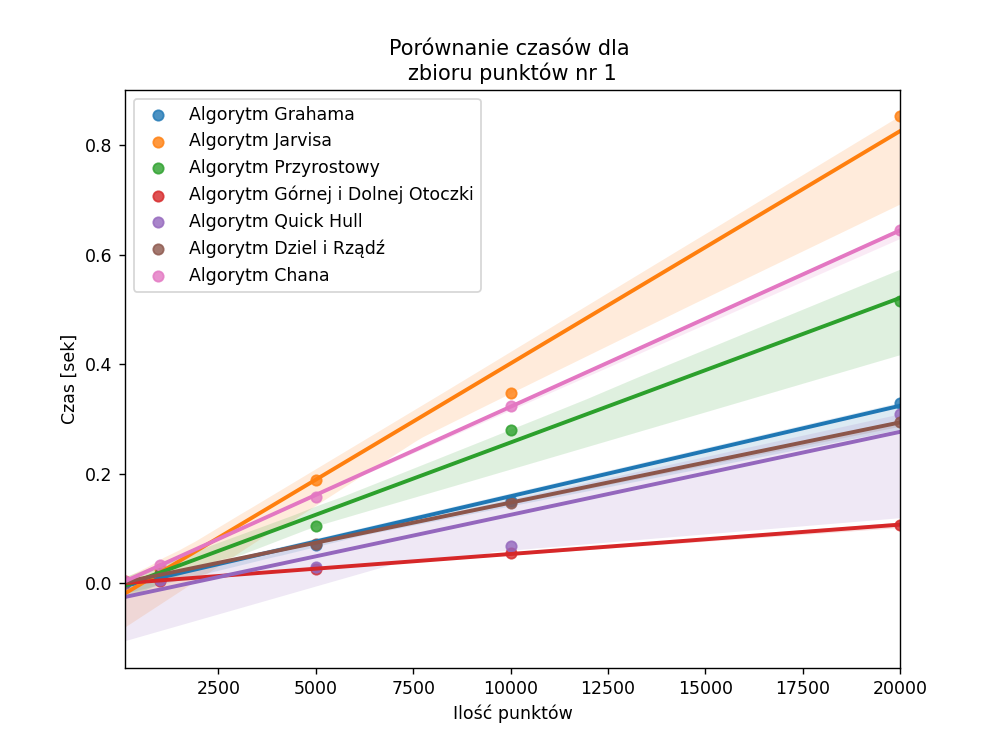

In [80]:
draw_tests(results_set_1, 1)

## Zbiór punktów nr 2

In [81]:
results_set_2 = performance_test(generate_set_2, 2, [100, 500, 1000, 1500, 2000])
print_tests(results_set_2)

Test 1 dla 100 punktów wykonany
Test 2 dla 500 punktów wykonany
Test 3 dla 1000 punktów wykonany
Test 4 dla 1500 punktów wykonany
Test 5 dla 2000 punktów wykonany


Ilość punktów,Algorytm Grahama [sek],Algorytm Jarvisa [sek],Algorytm Przyrostowy [sek],Algorytm Górnej i Dolnej Otoczki [sek],Algorytm Quick Hull [sek],Algorytm Dziel i Rządź [sek],Algorytm Chana [sek]
100,0.001410,0.016380,0.005350,0.000400,0.002040,0.001100,0.004170
500,0.006200,0.361730,0.132180,0.001940,0.013600,0.006190,0.029000
1000,0.011040,1.434720,0.535120,0.003990,0.029860,0.012950,0.058550
1500,0.018410,3.200300,1.162880,0.005940,0.047740,0.017770,0.089230
2000,0.024560,5.722050,2.158770,0.008020,0.066040,0.026060,0.120890


<IPython.core.display.Javascript object>


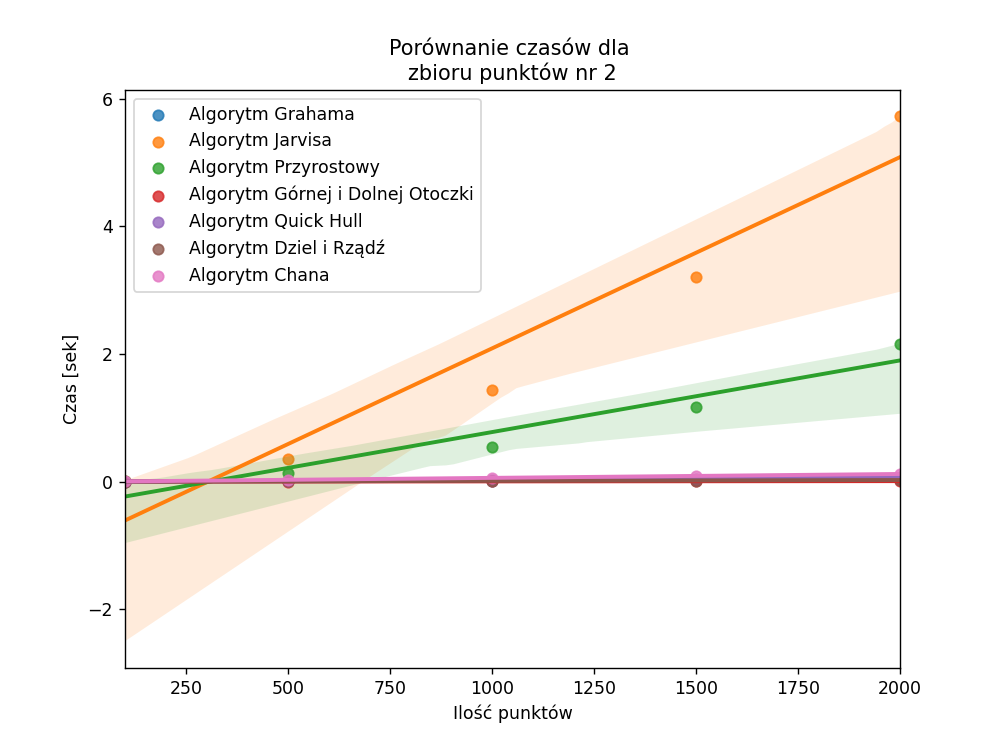

In [82]:
draw_tests(results_set_2, 2)

## Zbiór punktów nr 3

In [83]:
results_set_3 = performance_test(generate_set_3, 3, [100, 1000, 5000, 10000, 20000])
print_tests(results_set_3)

Test 1 dla 100 punktów wykonany
Test 2 dla 1000 punktów wykonany
Test 3 dla 5000 punktów wykonany
Test 4 dla 10000 punktów wykonany
Test 5 dla 20000 punktów wykonany


Ilość punktów,Algorytm Grahama [sek],Algorytm Jarvisa [sek],Algorytm Przyrostowy [sek],Algorytm Górnej i Dolnej Otoczki [sek],Algorytm Quick Hull [sek],Algorytm Dziel i Rządź [sek],Algorytm Chana [sek]
100,0.000940,0.002030,0.001160,0.000430,0.000800,0.004840,0.002900
1000,0.014180,0.019890,0.016420,0.004700,0.008650,0.055510,0.031010
5000,0.075570,0.100770,0.057770,0.023450,0.041540,0.259570,0.152380
10000,0.161780,0.207210,0.118480,0.047510,0.083690,0.522920,0.306990
20000,0.344590,0.397300,0.238600,0.098330,0.168960,1.040250,0.623370


<IPython.core.display.Javascript object>


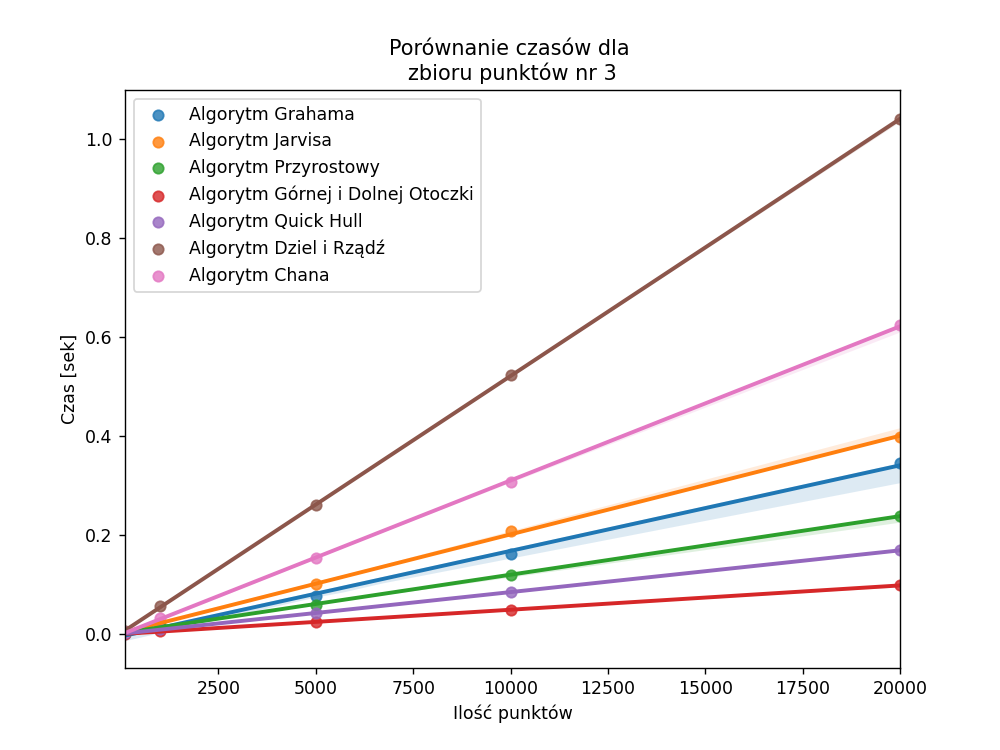

In [84]:
draw_tests(results_set_3, 3)

## Zbiór punktów nr 4

In [85]:
results_set_4 = performance_test(generate_set_4, 4, [100, 1000, 5000, 10000, 20000])
print_tests(results_set_4)

Test 1 dla 100 punktów wykonany
Test 2 dla 1000 punktów wykonany
Test 3 dla 5000 punktów wykonany
Test 4 dla 10000 punktów wykonany
Test 5 dla 20000 punktów wykonany


Ilość punktów,Algorytm Grahama [sek],Algorytm Jarvisa [sek],Algorytm Przyrostowy [sek],Algorytm Górnej i Dolnej Otoczki [sek],Algorytm Quick Hull [sek],Algorytm Dziel i Rządź [sek],Algorytm Chana [sek]
100,0.001160,0.001300,0.000630,0.000410,0.000460,0.003480,0.002370
1000,0.010530,0.012800,0.007060,0.004230,0.004490,0.039230,0.024020
5000,0.057290,0.060490,0.028020,0.022440,0.023790,0.188510,0.122320
10000,0.119380,0.300660,0.066800,0.044380,0.047540,0.377240,0.247830
20000,0.256250,0.247920,0.129570,0.090390,0.093320,0.758170,0.492140


<IPython.core.display.Javascript object>


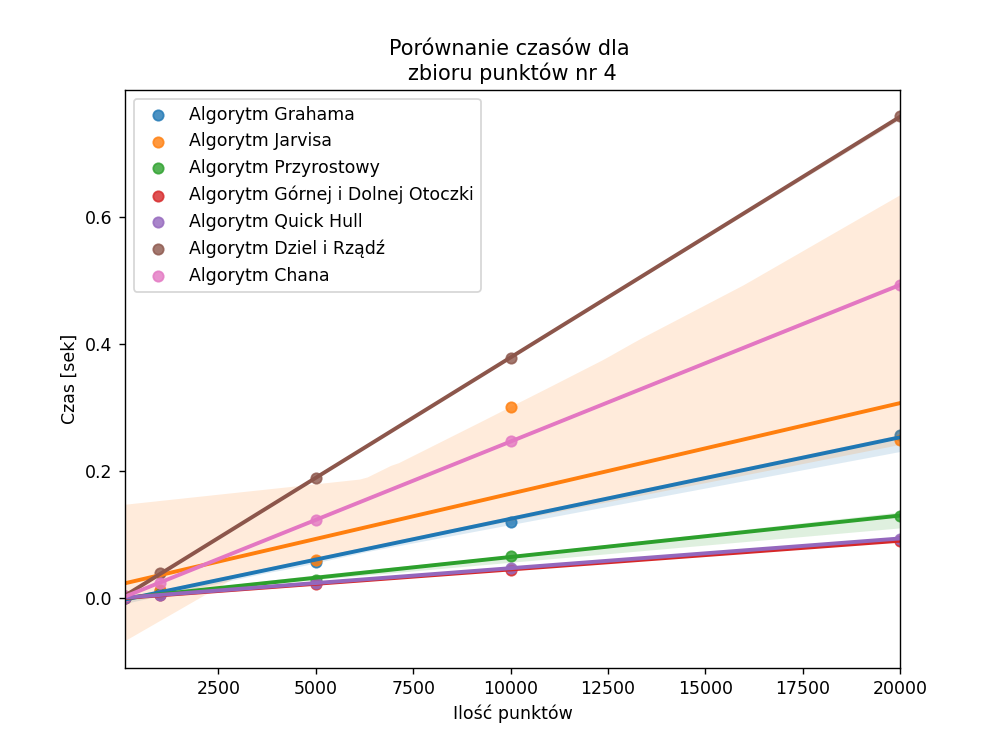

In [86]:
draw_tests(results_set_4, 4)